# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.

Most illustrative plots of how the pandemic is being controlled:
- [Relative increases per day by country](#country_relative_increases)
- [Relative increases per day by state](#us_state_relative_increases)

Visualizations found in this notebook:
- Countries
    - [Top 20 countries by cumulative confirmed COVID-19 cases](#top_countries_confirmed)
    - [Top 10 countries by NEW confirmed COVID-19 cases](#top_countries_confirmed_new)
    - [Time-series plots of infections in most infected countries](#time-series_countries)
    - [Forecasts of infections/deaths 1 and 7 days in the future](#forecasts_countries)
    - [Relative increases per day by country](#country_relative_increases)
    - [Time-series plots of mortality](#time-series_country_mortality)
    - [Mortality as currently measured, compared to expected based on WHO mortality expectations](#counry_mortality_expectations)
      - [Source of expectations](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)
    - [Density of infections per million people](#density_of_infections_by_country)
    - [How many days behind is each country from Italy?](#days_behind)
- US states
    - [US states with the most new infections](#states_most_infections)
    - [Time-series plots of infections in most-infected states](#time-series_states)
    - [State forecasts of infections/deaths 1 and 7 days in the future](#forecast_us_state)
    - [States and their daily increase fraction in confirmed cases/deaths](#us_state_daily_increase_fraction)
    - [Compare US state infections against Washington](#state_infections_vs_wa)
    - [Compare US state infections against New York](#state_infections_vs_ny)
    - [Mortality rate by US state](#mortality_by_us_state)
    - [Relative increases per day by state](#us_state_relative_increases)
    - [When will each US state hit 1 case?](#us_state_0_new)
    - [Smoothed trend for each US state](#us_state_smoothed_trend)

In [1]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# Imports and definitions

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt
import warnings

plt.rcParams['figure.figsize'] = 12,6
#plt.style.use('seaborn-dark-palette')
plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

def datetime_to_unixtime(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

# Load data

In [835]:
# define paths to each raw file
d_ts = {}
#d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
#d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [836]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [837]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')
        
print(f"Latest data from {dfp['date'].max().strftime('%Y-%m-%d')}")

metric: confirmed at 2020-06-16 22:16:18.863820
metric: deaths at 2020-06-16 22:16:21.081256
Latest data from 2020-06-16


In [838]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   #'recovered': np.sum,
               }))
#dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']
dfp_country['mortality_rate'] = dfp_country['deaths'] / dfp_country['confirmed']

<a id='top_countries_confirmed'></a>
##### Top 20 countries by cumulative confirmed COVID-19 cases

In [839]:
# get the top countries
id_cols = ['date', 'country']
value_cols = [
    'confirmed',
    'confirmed_new',
    'deaths',
    'deaths_new',
    #'active',
    'mortality_rate',
]
dfp_top_countries = dfp_country[dfp_country['date'] == dfp_country['date'].max()][id_cols + value_cols]
dfp_top_countries = dfp_top_countries.sort_values(by='deaths', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(20)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-06-16              US    2137731          23705  116963         836   
1  2020-06-16          Brazil     923189          34918   45241        1282   
2  2020-06-16  United Kingdom     299600           1285   42054         233   
3  2020-06-16           Italy     237500            210   34405          34   
4  2020-06-16          France     194347             42   29550         111   
5  2020-06-16           Spain     244328            219   27136           0   
6  2020-06-16          Mexico     154863           4599   18310         730   
7  2020-06-16           India     354065          10974   11903        2003   
8  2020-06-16         Belgium      60155             55    9663           2   
9  2020-06-16            Iran     192439           2563    9065         115   
10 2020-06-16         Germany     188252            570    8820          13   
11 2020-06-16          Canada     101087            324    8271          43   
12 2020-06-16          Russia     544725           8241    7274         193   
13 2020-06-16            Peru     237156           4164    7056         196   
14 2020-06-16     Netherlands      49295            140    6089           5   
15 2020-06-16          Sweden      53323            940    4939          48   
16 2020-06-16          Turkey     181298           1467    4842          17   
17 2020-06-16           China      84422             44    4638           0   
18 2020-06-16         Ecuador      47943            621    3970          41   
19 2020-06-16           Chile     184449           5013    3383          21   

    mortality_rate  
0         0.054714  
1         0.049005  
2         0.140367  
3         0.144863  
4         0.152048  
5         0.111064  
6         0.118234  
7         0.033618  
8         0.160635  
9         0.047106  
10        0.046852  
11        0.081821  
12        0.013354  
13        0.029753  
14        0.123522  
15        0.092624  
16        0.026707  
17        0.054938  
18        0.082807  
19        0.018341

<a id='top_countries_confirmed_new'></a>
##### Top 10 countries by NEW confirmed COVID-19 cases

In [840]:
dfp_top_countries.sort_values(by='confirmed_new', ascending=0).head(10)

date       country  confirmed  confirmed_new  deaths  deaths_new  \
1  2020-06-16        Brazil     923189          34918   45241        1282   
0  2020-06-16            US    2137731          23705  116963         836   
7  2020-06-16         India     354065          10974   11903        2003   
12 2020-06-16        Russia     544725           8241    7274         193   
20 2020-06-16      Pakistan     154760           5839    2975         136   
19 2020-06-16         Chile     184449           5013    3383          21   
6  2020-06-16        Mexico     154863           4599   18310         730   
32 2020-06-16  Saudi Arabia     136315           4267    1052          41   
13 2020-06-16          Peru     237156           4164    7056         196   
30 2020-06-16    Bangladesh      94481           3862    1262          53   

    mortality_rate  
1         0.049005  
0         0.054714  
7         0.033618  
12        0.013354  
20        0.019223  
19        0.018341  
6         0.118234  
32        0.007717  
13        0.029753  
30        0.013357

<a id='time-series_countries'></a>
# Time-series plots of infections in most infected countries

In [841]:
def plot_countries(
    dfp_country,
    countries=dfp_top_countries.iloc[:10]['country'],
    plot_cols=['confirmed', 'deaths', 'recovered', 'active', 'confirmed_new'],
    country_col='country',
    n_columns=2,
    y_min=1,
    y_max=dfp_top_countries['confirmed'].max() * 1.5,
    date_col='date',
    y_label='num_cases',
    date_min=datetime.datetime(2020,2,1),
    is_log=True,
):
    i = 1
    n_rows = int(np.ceil(len(countries) / n_columns))
    plt.figure(figsize=(12,n_rows*5))
    
    for country in countries:
        dfp_plot = dfp_country[(dfp_country[country_col] == country) &
                               (dfp_country[date_col] >= date_min)
                              ]
        dfp_plot = dfp_plot[dfp_plot['confirmed_new'] != 0]
        plt.subplot(n_rows, n_columns, i)
        for key in plot_cols:
            plt.plot(dfp_plot[date_col], dfp_plot[key], alpha=0.7, label=key)
        plt.legend(loc='best')
        plt.ylabel(f'{y_label}')
        plt.title(f'{country_col}: {country}')
        if is_log:
            plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()

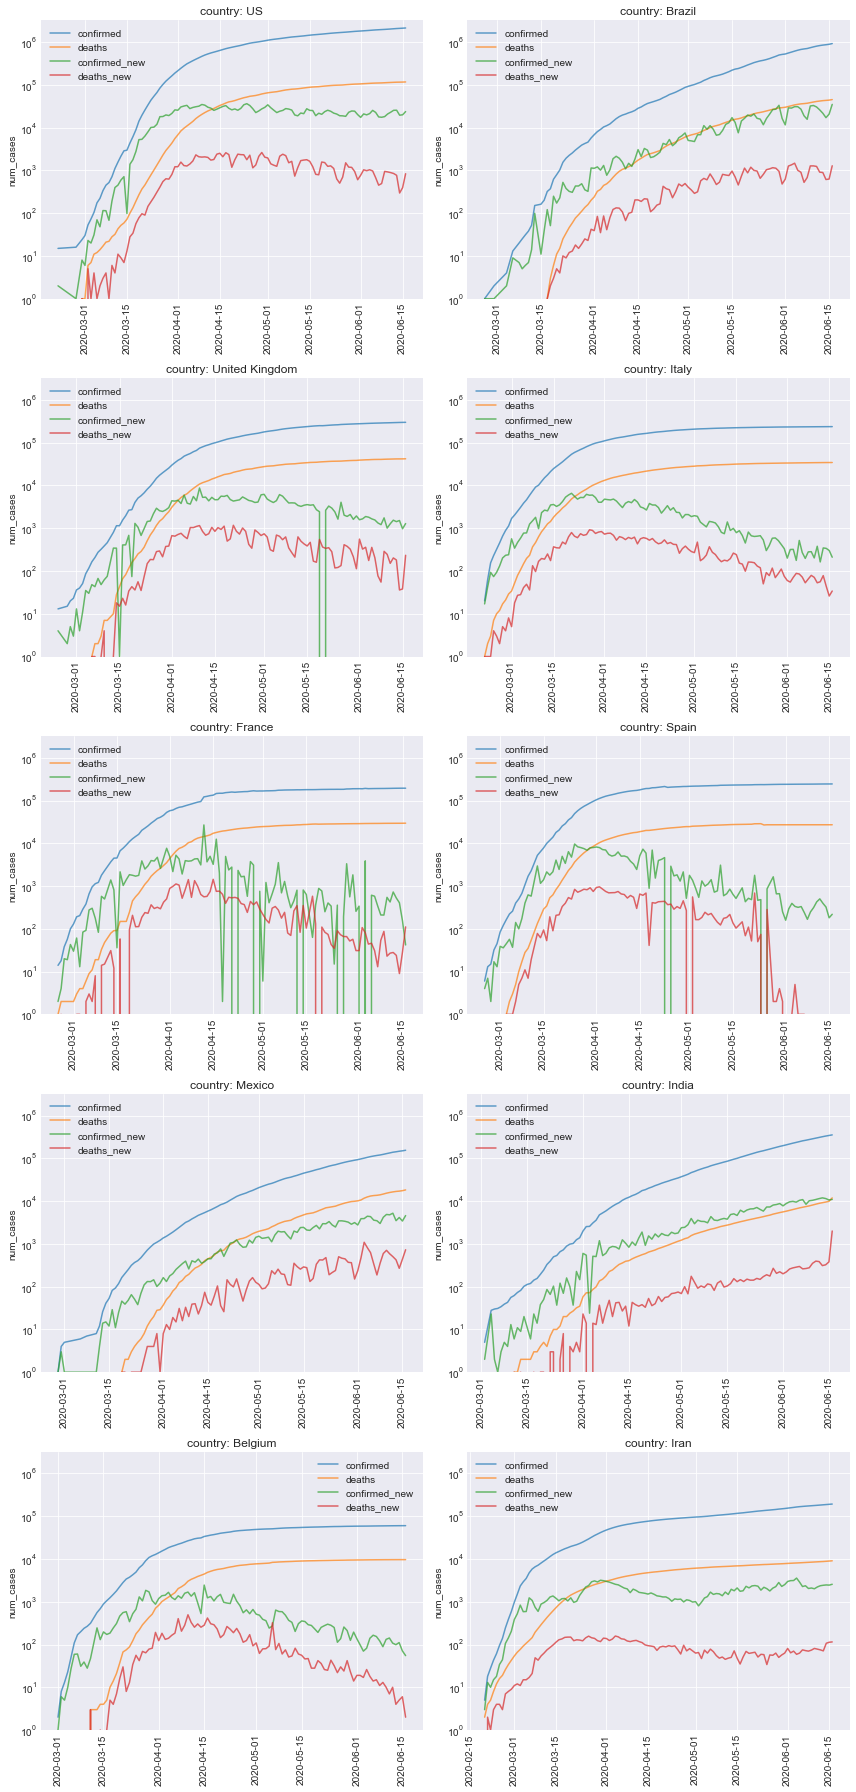

In [842]:
n_countries = 10

plot_countries(dfp_country, 
               countries=dfp_top_countries.iloc[:n_countries]['country'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

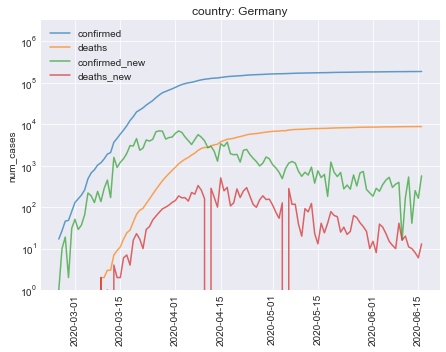

In [843]:
plot_countries(dfp_country, 
               countries=['Germany'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

<a id='forecasts_countries'></a>
# Forecasts of infections/deaths 1 and 7 days in the future

For confirmed cases (`confirmed_pred`) and deaths (`deaths_pred`)

In [844]:
def predict_from_fit(row):
    return int(10**(row['slope'] * row['unixtime'] + row['intercept']))

def shift_future(dfp, date_most_recent, days=1, cols_to_be_null_in_future=[]):
    dfp_most_recent = dfp.copy()
    dfp_most_recent['date'] = date_most_recent + datetime.timedelta(days=days)  #dfp_most_recent['date'] + datetime.timedelta(days=days)
    dfp_most_recent['unixtime'] = dfp_most_recent['date'].apply(datetime_to_unixtime)
    #dfp_most_recent['unixtime'] = dfp_most_recent['unixtime'] + 86400 * days
    
    cols_nullable = ['confirmed', 'deaths', 'recovered', 'active', 'confirmed_lag1', 'confirmed_new', 'deaths_new']
    cols_nullable.extend(cols_to_be_null_in_future)
    for col in cols_nullable:
        dfp_most_recent[col] = np.nan
    return dfp_most_recent

def fit_poly1(dfp_country_recent, 
              col_fit='confirmed_log', 
              col_pred='confirmed_pred', 
              date_most_recent=None,
              col_locale='country'
             ):
    warnings.simplefilter('ignore', np.RankWarning)
    if date_most_recent is None:
        date_most_recent = dfp_country_recent['date'].max()
    dfp_country_recent = dfp_country_recent.set_index(col_locale)
    
    # fit
    dfp_country_recent_clean = dfp_country_recent[(dfp_country_recent['date'] <= date_most_recent) &
                                                  (dfp_country_recent[col_fit] > 0)
                                                 ]
    dfp_country_confirmed_fit = (dfp_country_recent[dfp_country_recent['date'] <= date_most_recent].
                                 groupby([col_locale]).
                                 apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1))
                                )
    dfp_country_recent['fits'] = dfp_country_confirmed_fit
    dfp_country_recent[['slope', 'intercept']] = dfp_country_recent['fits'].apply(pd.Series)   
    
    dfp_country_recent[col_pred] = dfp_country_recent.apply(predict_from_fit, axis=1)
    dfp_country_recent = dfp_country_recent.drop(columns=['fits', 'intercept']).reset_index() #'slope', 
    fit_col = col_fit.split('_')[0]
    dfp_country_recent[f"frac_increase_{fit_col}"] = (10**(dfp_country_recent['slope'] * 86400) - 1)
    #dfp_country_recent = dfp_country_recent.rename(columns={'slope': f'slope_{col_fit.split("_")[0]}'})
    return dfp_country_recent, dfp_country_confirmed_fit

def fit_exp(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False
           ):
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    dfp_country_recent['confirmed_log'] = dfp_country_recent['confirmed'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['deaths_log'] = dfp_country_recent['deaths'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    #dfp_most_recent = dfp_country_recent[dfp_country_recent['date'] == date_most_recent].copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    #dfp_most_recent_7 = shift_future(dfp_most_recent, 7)
    #dfp_country_recent = pd.concat([dfp_country_recent, dfp_most_recent_1, dfp_most_recent_7], axis=0, sort=False)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                           col_fit='deaths_log', 
                                                           col_pred='deaths_pred', 
                                                           col_locale=col_locale, 
                                                           date_most_recent=date_most_recent
                                                          )
    dfp_country_recent, dfp_country_confirmed_fit = fit_poly1(dfp_country_recent, 
                                                              col_fit='confirmed_log', 
                                                              col_pred='confirmed_pred', 
                                                              col_locale=col_locale, 
                                                              date_most_recent=date_most_recent
                                                             )
    dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    dfp_forecasts_out = dfp_forecasts[['date', 
                                       col_locale, 
                                       'confirmed_pred', 
                                       'deaths_pred', 
                                       'mortality_rate_pred', 
                                       'frac_increase_confirmed', 
                                       'frac_increase_deaths'
                                      ]].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({'frac_increase_confirmed': np.mean, 
                              'frac_increase_deaths': np.mean}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=['confirmed_pred', 'deaths_pred', 'mortality_rate_pred']
                                                 ).sort_values(by=('deaths_pred', dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                  ):
    # subset the top countries
    dfp_non_pred = dfp_country_recent.dropna(subset=['deaths'])
    dt_max = dfp_non_pred['date'].max()
    dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                         sort_values(by='deaths', ascending=0).
                         iloc[:n_countries]
                        )
    top_countries = (dfp_top_countries.
                     iloc[:n_countries][col_locale].values
                    )

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    y_max = dfp_country_recent['confirmed_pred'].max()
    y_min = max(dfp_country_recent['deaths'].min(), 1)

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        plt.subplot(n_rows, n_columns, i)
        for key in ['confirmed', 'deaths']:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast(dfp_forecasts_out, dfp_country_recent, n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"covid-19_country_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

##### Forecasts based on last 1 week

confirmed_pred                       deaths_pred             \
date               2020-06-17 2020-06-23 2020-07-07  2020-06-17 2020-06-23   
country                                                                      
US                  2163111.0  2310664.0  2695289.0    117658.0   121617.0   
Brazil               946491.0  1119393.0  1655781.0     46108.0    52122.0   
United Kingdom       301156.0   309542.0   330027.0     42174.0    42975.0   
Italy                237835.0   239605.0   243788.0     34476.0    34779.0   
France               195110.0   197590.0   203500.0     29535.0    29728.0   
Spain                244836.0   246929.0   251883.0     27136.0    27136.0   
Mexico               160007.0   191024.0   288826.0     18718.0    22048.0   
India                368400.0   455671.0   748331.0     11648.0    16162.0   
Belgium               60293.0    60888.0    62301.0      9671.0     9706.0   
Iran                 194928.0   210860.0   253284.0      9136.0     9732.0   

                          mortality_rate_pred                        \
date           2020-07-07          2020-06-17 2020-06-23 2020-07-07   
country                                                               
US               131380.0            0.054393   0.052633   0.048744   
Brazil            69383.0            0.048715   0.046563   0.041903   
United Kingdom    44903.0            0.140040   0.138834   0.136059   
Italy             35499.0            0.144958   0.145151   0.145614   
France            30185.0            0.151376   0.150453   0.148329   
Spain             27135.0            0.110833   0.109894   0.107729   
Mexico            32310.0            0.116982   0.115420   0.111867   
India             34709.0            0.031618   0.035469   0.046382   
Belgium            9787.0            0.160400   0.159407   0.157092   
Iran              11277.0            0.046869   0.046154   0.044523   

               frac_increase_confirmed frac_increase_deaths  
date                                                         
country                                                      
US                            0.011059         5.531051e-03  
Brazil                        0.028358         2.064306e-02  
United Kingdom                0.004588         3.140086e-03  
Italy                         0.001237         1.463444e-03  
France                        0.002107         1.089285e-03  
Spain                         0.001420        -3.330669e-16  
Mexico                        0.029971         2.767077e-02  
India                         0.036069         5.611014e-02  
Belgium                       0.001639         5.962167e-04  
Iran                          0.013180         1.058428e-02

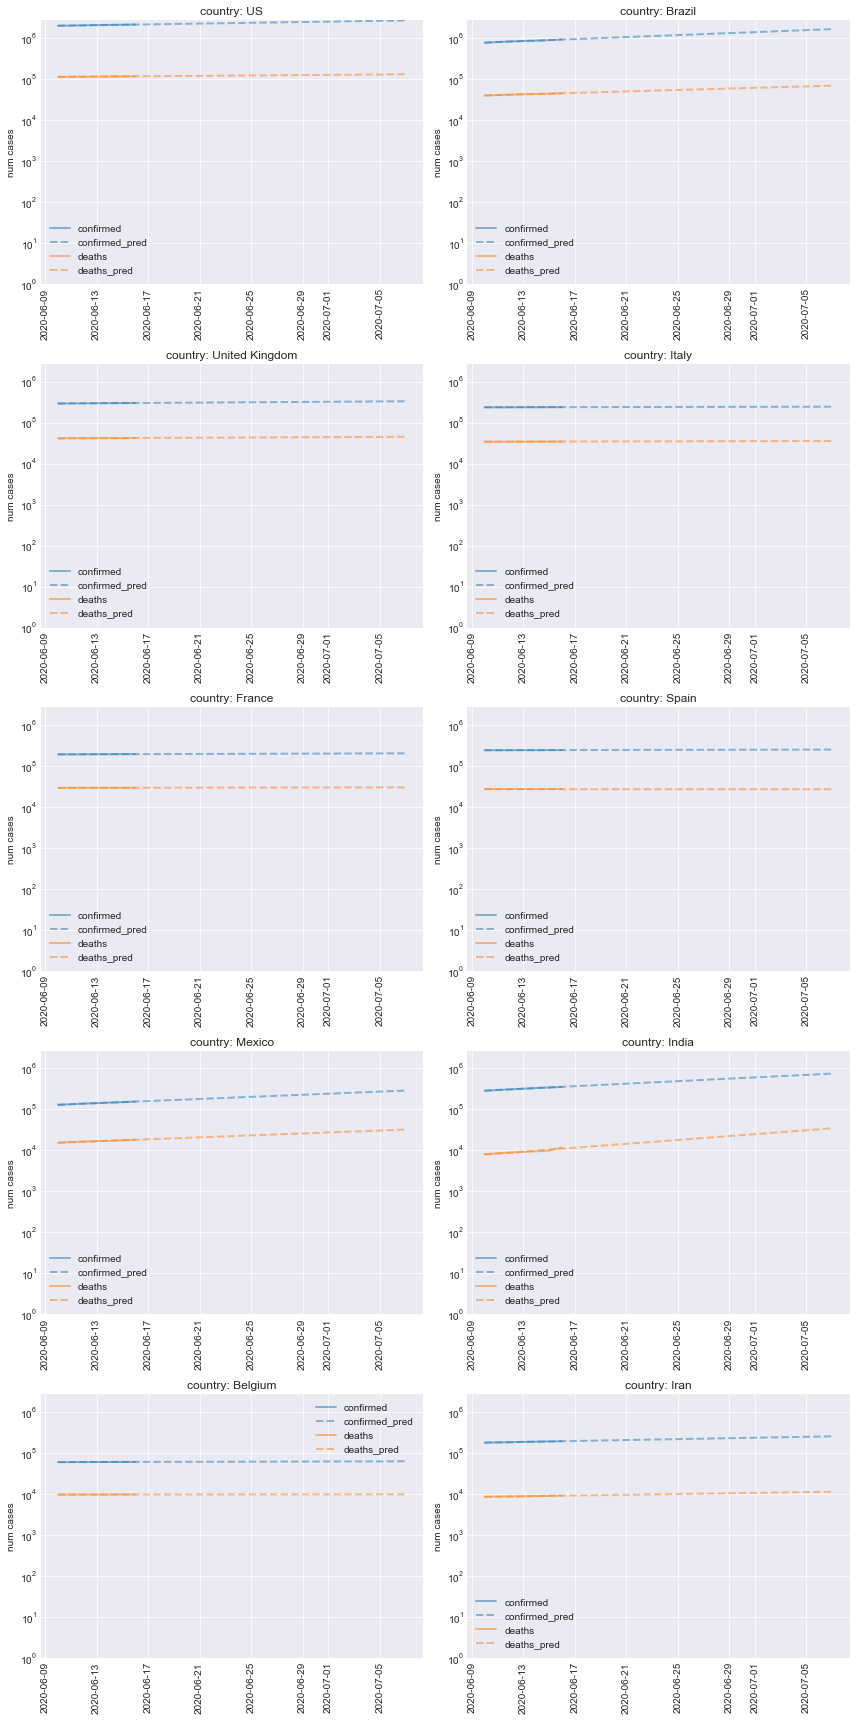

In [845]:
dfp_country_recent_1, dfp_forecasts_out_1 = fit_exp(dfp_country, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21], 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_1)

In [846]:
save_forecast(dfp_forecasts_out_1, dfp_country_recent_1, 7)

saved forecast to predictions/covid-19_country_forecast_from_2020-06-16_n_days_training=7.csv


<a id='country_relative_increases'></a>
### Relative increases per day by country

In [847]:
def find_relative_increase_data_and_plot(dfp_us_g, 
                                         n_days_fit=7, 
                                         dt=datetime.datetime(2020,3,10),
                                         n_locales=7,
                                         col_locale='state'
                                        ):
    dt_max = dfp_us_g['date'].max()
    list_dfp_state_relative = []
    while dt <= dt_max:
        try:
            dfp_state_recent_tmp, dfp_state_forecasts_out_tmp = fit_exp(dfp_us_g, 
                                                                        n_days_predict=n_days_fit, 
                                                                        col_locale=col_locale, 
                                                                        top_countries=None,
                                                                        date_most_recent=dt,
                                                                        is_silent=True
                                                                       )
            dfp_state_recent_tmp = dfp_state_recent_tmp.dropna(subset=['confirmed'])
            dfp_state_recent_tmp_single = dfp_state_recent_tmp[dfp_state_recent_tmp['date'] == dfp_state_recent_tmp['date'].max()]
            list_dfp_state_relative.append(dfp_state_recent_tmp_single)
        except Exception as e:
            print(f"failed on {dt.strftime('%Y-%m-%d')}")

        dt += datetime.timedelta(days=1)
    dfp_state_relative_chng = pd.concat(list_dfp_state_relative)
                  
    # plot states
    top_states = (dfp_state_relative_chng[(dfp_state_relative_chng['date'] == dfp_state_relative_chng['date'].max())].
                  sort_values(by='deaths', ascending=0).
                  reset_index(drop=True).
                  iloc[:n_locales][col_locale].values
                 )
                  
    # deaths
    plt.subplot(1,2,1)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        #
        plt.plot(dfp_st['date'], dfp_st['frac_increase_deaths'], label=state, alpha=0.7)
        plt.ylabel('relative increase in deaths')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in deaths')

    # confirmed cases
    plt.subplot(1,2,2)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        
        plt.plot(dfp_st['date'], dfp_st['frac_increase_confirmed'], label=state, alpha=0.7)
        plt.ylabel('relative increase in confirmed')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in confirmed')

    plt.show()
    return None


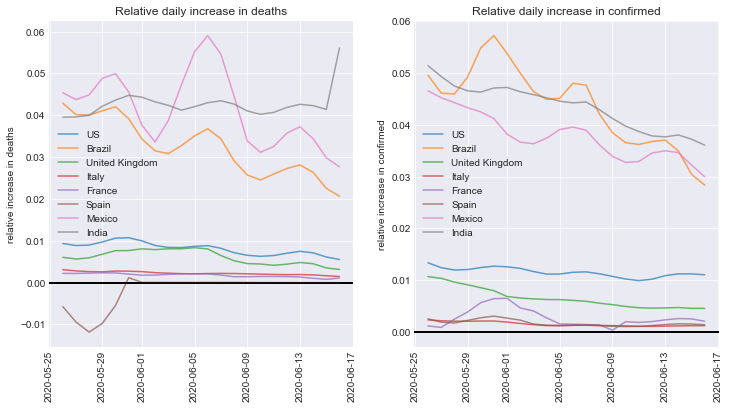

In [848]:
now = datetime.datetime.now()
now = datetime.datetime(now.year, now.month, now.day)
n_days_back = 21
dt_start = now - datetime.timedelta(days=n_days_back)
#dt_start = datetime.datetime(2020,3,2)
find_relative_increase_data_and_plot(dfp_country, n_locales=8, col_locale='country', dt=dt_start)

##### Forecasts based on last 2 weeks

confirmed_pred            deaths_pred             \
date               2020-06-17 2020-06-23  2020-06-17 2020-06-23   
country                                                           
US                  2160897.0  2304171.0    118050.0   122730.0   
Brazil               969291.0  1191041.0     46806.0    54283.0   
United Kingdom       301459.0   310243.0     42332.0    43404.0   
Italy                237807.0   239518.0     34526.0    34911.0   
France               194697.0   196706.0     29555.0    29781.0   
Spain                244717.0   246644.0     27137.0    27139.0   
Mexico               161757.0   196670.0     19062.0    23160.0   
India                371808.0   466088.0     11224.0    14660.0   
Belgium               60376.0    61103.0      9690.0     9753.0   
Iran                 195164.0   211240.0      9093.0     9616.0   

               mortality_rate_pred            frac_increase_confirmed  \
date                    2020-06-17 2020-06-23                           
country                                                                 
US                        0.054630   0.053264                0.010757   
Brazil                    0.048289   0.045576                0.034933   
United Kingdom            0.140424   0.139903                0.004799   
Italy                     0.145185   0.145755                0.001195   
France                    0.151800   0.151399                0.001712   
Spain                     0.110891   0.110033                0.001308   
Mexico                    0.117843   0.117761                0.033109   
India                     0.030188   0.031453                0.038384   
Belgium                   0.160494   0.159616                0.001998   
Iran                      0.046592   0.045522                0.013280   

               frac_increase_deaths  
date                                 
country                              
US                         0.006501  
Brazil                     0.025006  
United Kingdom             0.004175  
Italy                      0.001847  
France                     0.001270  
Spain                      0.000013  
Mexico                     0.032992  
India                      0.045507  
Belgium                    0.001081  
Iran                       0.009350

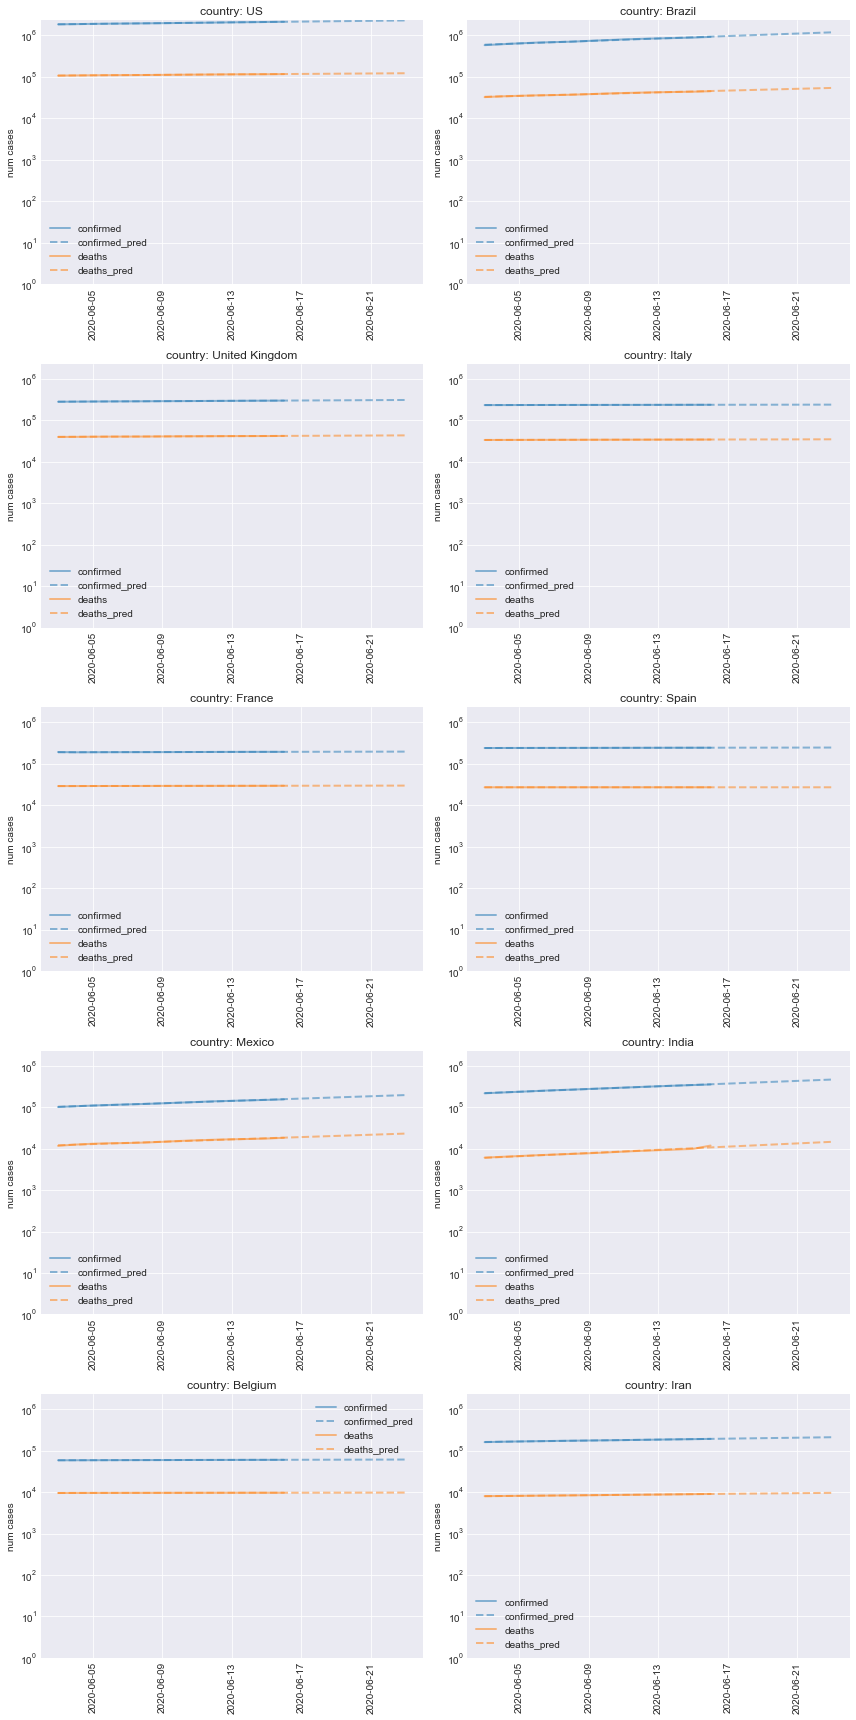

In [849]:
dfp_country_recent_2, dfp_forecasts_out_2 = fit_exp(dfp_country, 
                                                    n_days_predict=14, 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_2)

In [850]:
save_forecast(dfp_forecasts_out_2, dfp_country_recent_2, 14)

saved forecast to predictions/covid-19_country_forecast_from_2020-06-16_n_days_training=14.csv


<a id='time-series_country_mortality'></a>
# Time-series plots of mortality

In [851]:
def plot_mortality_rate(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    dfp_country_mortality_expected=None
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        p = plt.plot(dfp_plot['date'], dfp_plot['mortality_rate'], label=locale, alpha=0.7)
        
        if dfp_country_mortality_expected is not None:
            dfp_expected = dfp_country_mortality_expected[dfp_country_mortality_expected['country'] == locale]
            
            color = p[0].get_color()
            expected = dfp_expected['frac_mortality'].values[0]
            plt.axhline(expected, 
                        color=color, 
                        alpha=0.5, 
                        linestyle='--', 
                        label=f'{locale} expected = {expected:0.4f}'
                       )
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if upper_lim is not None:
        plt.ylim([0,upper_lim])
    #plt.yscale('log')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

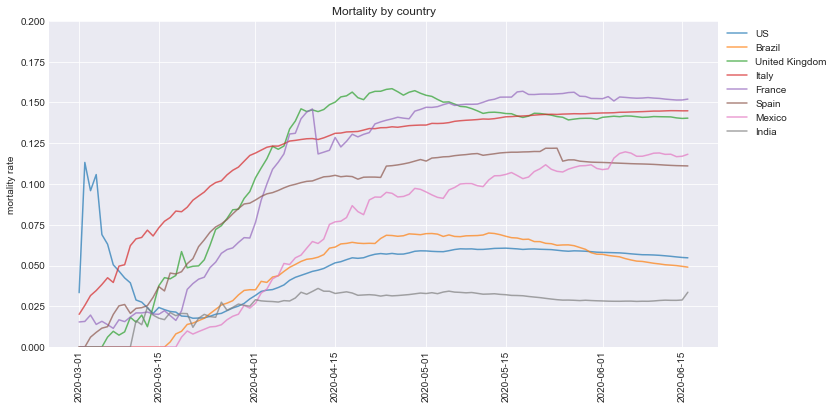

In [852]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

### Is mortality rate a function of number of infections?

In [853]:
def plot_mortality_rate_vs_infections(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    x_col='confirmed',
    y_col='mortality_rate'
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        plt.plot(dfp_plot[x_col], dfp_plot[y_col], 'o', label=locale, alpha=0.3)
    plt.legend(loc='best')
    #plt.ylim([0,upper_lim])
    plt.gca().set_ylim(top=upper_lim)
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlabel('# confirmed cases')
    #plt.ylabel('mortality rate')
    plt.xlabel(x_col.replace('_', ' '))
    plt.ylabel(y_col.replace('_', ' '))
    plt.title(f'{y_col} vs {x_col} by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

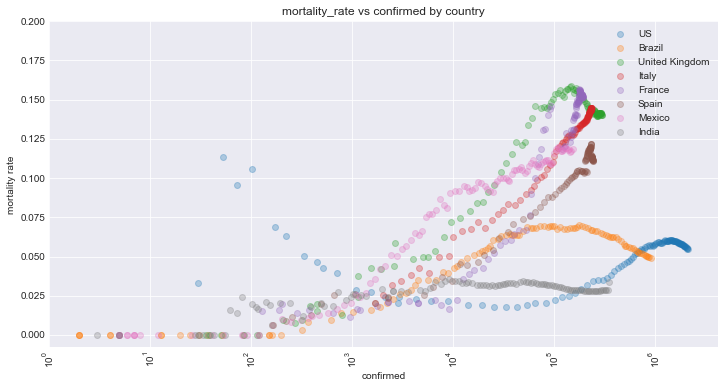

In [854]:
plot_mortality_rate_vs_infections(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

# Compare mortality rate to expected given country demographics and mortality by age data?

- Country demographic data source: https://www.census.gov/data-tools/demo/idb/region.php?T=10&RT=0&A=both&Y=2020&C=AF&R=1
- Mortality by age source: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [855]:
# mortality data
d_mortality = {0: 0, 10: 0.002, 20: 0.002, 30: 0.002, 40: 0.004, 50: 0.013, 60: 0.036, 70: 0.08, 80: 0.148, 90: 0.148, 100: 0.148}
dfp_mortality = pd.DataFrame.from_dict(d_mortality, orient='index', columns=['mortality_rate']).reset_index(drop=False)
dfp_mortality = dfp_mortality.rename(columns={'index': 'age_decade'})

# demographic data
dfp_demo = pd.read_csv('supporting_data/census_data_20200320_10a682338c.csv', skiprows=1, skipinitialspace=True)

# clean demographic data
dfp_demo = dfp_demo[(dfp_demo['Region'] == 'World') & (dfp_demo['Age'] != 'Total')]
dfp_demo['age_min'] = dfp_demo['Age'].apply(lambda x: np.min([int(y) for y in re.findall('(\d+)', x)]))
dfp_demo['age_mid'] = dfp_demo['age_min'] + 2.5
dfp_demo['age_decade'] = dfp_demo['age_min'].apply(lambda x: int(x / 10) * 10)
dfp_demo = dfp_demo.rename(columns={'Percent Both Sexes': 'pct_pop', 
                                    'Country': 'country',
                                    'Both Sexes Population': 'pop'
                                   })
dfp_demo_decade = dfp_demo.groupby(['country', 'age_decade'], as_index=False).agg({'pct_pop': np.sum, 'pop': np.sum})
dfp_demo_decade.loc[dfp_demo_decade['country'] == 'United States', 'country'] = 'US'

# join mortality with demographics
dfp_demo_decade_mortality = (dfp_demo_decade.merge(dfp_mortality, on=['age_decade'], how='inner').
                             sort_values(by=['country', 'age_decade']).
                             reset_index(drop=True)
                            )
dfp_demo_decade_mortality['frac_mortality'] = dfp_demo_decade_mortality['pct_pop'] * dfp_demo_decade_mortality['mortality_rate'] / 100
dfp_demo_decade_mortality['num_deaths_max_expected'] = dfp_demo_decade_mortality['pop'] * dfp_demo_decade_mortality['mortality_rate']
dfp_country_mortality_expected = (dfp_demo_decade_mortality.
                                  groupby(['country'], as_index=False).
                                  agg({'frac_mortality': np.sum, 
                                       'num_deaths_max_expected': np.sum, 
                                       'pop': np.sum
                                      })
                                 )
dfp_country_mortality_expected.loc[dfp_country_mortality_expected['country'] == 'United States', 'country'] = 'US'

### Age distributions for most infected countries

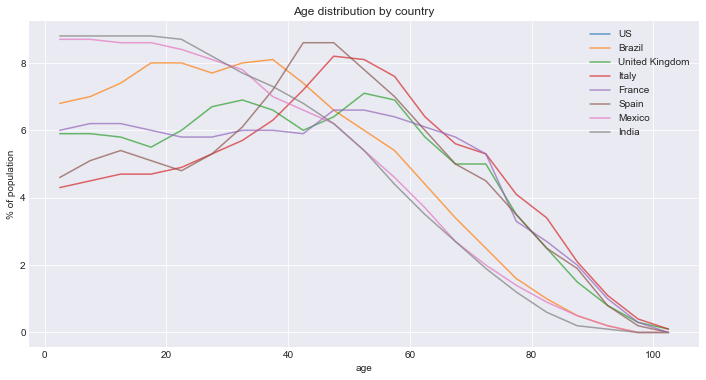

In [856]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']
for country in countries:
    dfp_plot = dfp_demo[dfp_demo.country == country]
    plt.plot(dfp_plot['age_mid'], dfp_plot['pct_pop'], alpha=0.7, label=country)
plt.xlabel('age')
plt.ylabel('% of population')
plt.title('Age distribution by country')
plt.legend(loc='best')
plt.show()

<a id='counry_mortality_expectations'></a>
### Mortality as currently measured, compared to expected based on WHO mortality expectations

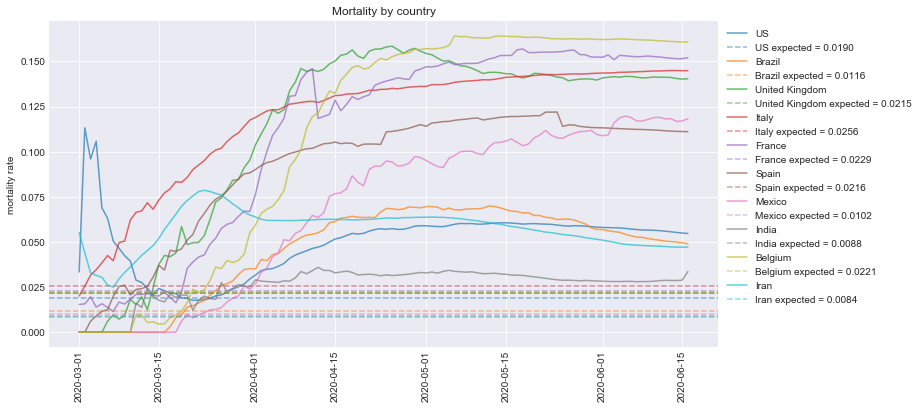

date         country  mortality_rate  confirmed    deaths
0 2020-06-16         Belgium        0.160635    60155.0    9663.0
1 2020-06-16          France        0.152048   194347.0   29550.0
2 2020-06-16           Italy        0.144863   237500.0   34405.0
3 2020-06-16  United Kingdom        0.140367   299600.0   42054.0
4 2020-06-16          Mexico        0.118234   154863.0   18310.0
5 2020-06-16           Spain        0.111064   244328.0   27136.0
6 2020-06-16              US        0.054714  2137731.0  116963.0
7 2020-06-16          Brazil        0.049005   923189.0   45241.0
8 2020-06-16            Iran        0.047106   192439.0    9065.0
9 2020-06-16           India        0.033618   354065.0   11903.0

In [857]:
n_countries = 10
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=None, id_col='country', date_min=datetime.datetime(2020,3,1), dfp_country_mortality_expected=dfp_country_mortality_expected)
dfp_display = (dfp_country[(dfp_country['date'] == dfp_country['date'].max()) & 
                           (dfp_country['country'].isin(countries))
                          ].
               sort_values(by='mortality_rate', ascending=0).
               reset_index(drop=True)
              )[['date', 'country', 'mortality_rate', 'confirmed', 'deaths']]
display(dfp_display)

**Remarks about the mortality rate being above the expected mortality rate**

Assuming the [cited report](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) of age-wise mortality is correct and that the virus is homogeneously distributed amongst the population, a discrepancy like this could arise if the country has:
- Preferentially tested people in critical condition, ignoring test for mild cases (perhaps if testing capacity is saturated)
- An overloaded hospital system, where patients are not receiving the same quality of care they would otherwise

If the testing is biased, we can estimate the true number of infections by multiplying the confirmed cases by the ratio between the measured mortality rate and the expected mortality rate.  For example, in Iran (as of 2020-03-22), we might estimate the true number of cases is 9.3x higher using this method (200,589 vs 21,638).

### Distribution of expected mortality fractions

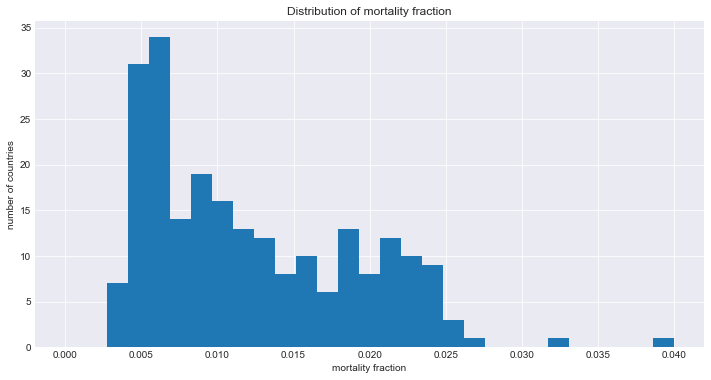

In [858]:
dfp_country_mortality_expected['frac_mortality'].hist(bins=np.linspace(0,0.04,30))
plt.title('Distribution of mortality fraction')
plt.ylabel('number of countries')
plt.xlabel('mortality fraction')
plt.show()

### Top expected mortality fractions based on age demographics
For countries with populations greater than 10 million.

In [859]:
dfp_country_mortality_expected = dfp_country_mortality_expected.sort_values(by='frac_mortality', ascending=0).reset_index(drop=True)
dfp_country_mortality_expected[dfp_country_mortality_expected['pop'] > 1E7].head(10)

country  frac_mortality  num_deaths_max_expected        pop
1         Japan        0.031837              3998380.024  125507472
2       Germany        0.026398              2128411.026   80159662
3        Greece        0.025745               271233.247   10607051
4         Italy        0.025637              1599267.592   62402659
10     Portugal        0.023736               244829.259   10302674
18       France        0.022950              1564984.503   67848156
20       Sweden        0.022575               231555.716   10202491
23      Belgium        0.022146               259573.363   11720716
24  Netherlands        0.022076               382222.125   17280397
27       Canada        0.021712               820035.480   37694085

<a id='density_of_infections_by_country'></a>
# Density of infections per million people

In [860]:
# plot of country fractions that are infected
dfp_country_pop = dfp_country.merge(dfp_country_mortality_expected[['country', 'pop']], on='country', how='left').copy()
dfp_country_pop['deaths_per_million'] = dfp_country_pop['deaths'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_per_million'] = dfp_country_pop['confirmed'] / dfp_country_pop['pop'] * 1E6

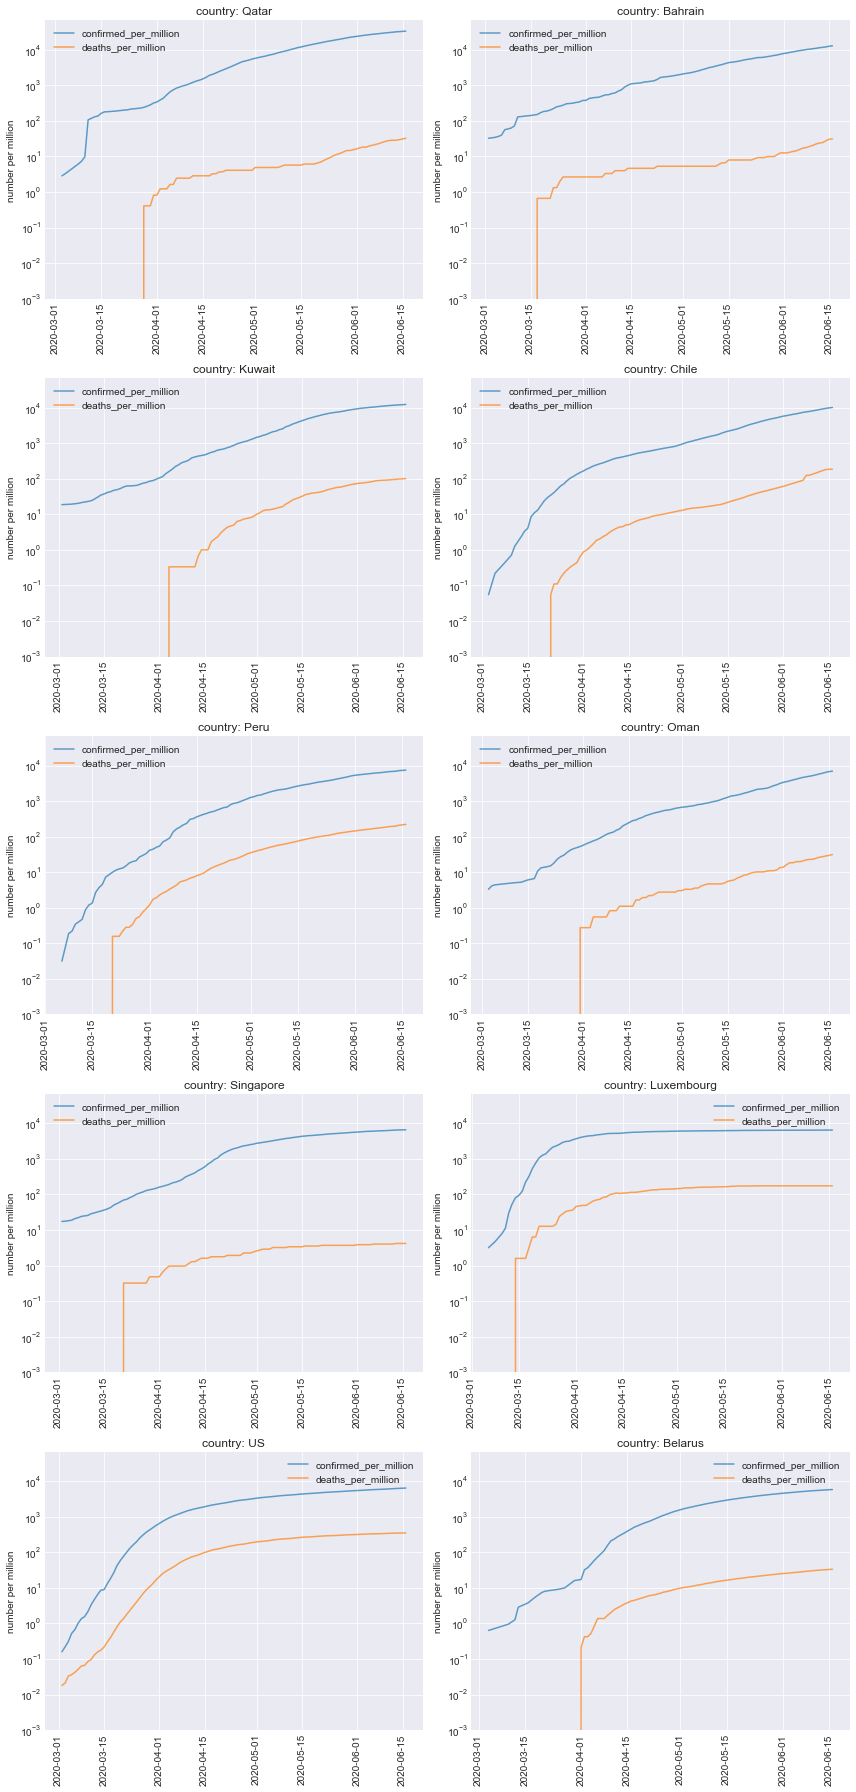

country   population  confirmed    deaths  confirmed_per_million  \
0       Qatar    2444174.0    82077.0      80.0           33580.669789   
1     Bahrain    1505003.0    19553.0      47.0           12992.000680   
2      Kuwait    2993706.0    36958.0     303.0           12345.233633   
3       Chile   18186770.0   184449.0    3383.0           10141.932845   
4        Peru   31914989.0   237156.0    7056.0            7430.865792   
5        Oman    3634689.0    25269.0     114.0            6952.176651   
6   Singapore    6209660.0    40969.0      26.0            6597.623702   
7  Luxembourg     628381.0     4075.0     110.0            6484.919181   
8          US  332639102.0  2137731.0  116963.0            6426.577595   
9     Belarus    9477918.0    55369.0     318.0            5841.894813   

   deaths_per_million  mortality_rate  
0           32.730894        0.000975  
1           31.229174        0.002404  
2          101.212343        0.008198  
3          186.014339        0.018341  
4          221.087339        0.029753  
5           31.364444        0.004511  
6            4.187025        0.000635  
7          175.053033        0.026994  
8          351.621320        0.054714  
9           33.551672        0.005743

In [861]:
n_countries = 10
dfp_country_pop_top = (dfp_country_pop[(dfp_country_pop['date'] == dfp_country_pop['date'].max()) &
                                       (dfp_country_pop['pop'] >= 1E5)
                                      ].
                       sort_values(by='confirmed_per_million', ascending=0).
                       reset_index(drop=True)
                      )

plot_countries(dfp_country_pop, 
               countries=dfp_country_pop_top.iloc[:n_countries]['country'],
               plot_cols=['confirmed_per_million', 'deaths_per_million'],
               country_col='country',
               y_max=dfp_country_pop['confirmed_per_million'].max()*2,
               y_min=0.001,
               y_label='number per million',
               date_min=datetime.datetime(2020,3,2)
              )
display_cols = ['country', 'pop', 'confirmed', 'deaths', 'confirmed_per_million', 'deaths_per_million', 'mortality_rate']
display(dfp_country_pop_top[display_cols].rename(columns={'pop': 'population'}).head(10))

In [862]:
dfp_country_pop_top[display_cols].sort_values(by='deaths_per_million', ascending=0).head(10)

country          pop  confirmed    deaths  confirmed_per_million  \
15         Belgium   11720716.0    60155.0    9663.0            5132.365634   
19  United Kingdom   65761117.0   299600.0   42054.0            4555.883684   
24           Italy   62402659.0   237500.0   34405.0            3805.927565   
18           Spain   50015792.0   244328.0   27136.0            4885.017116   
13          Sweden   10202491.0    53323.0    4939.0            5226.468712   
29          France   67848156.0   194347.0   29550.0            2864.440413   
30     Netherlands   17280397.0    49295.0    6089.0            2852.654369   
8               US  332639102.0  2137731.0  116963.0            6426.577595   
17         Ireland    5176569.0    25334.0    1709.0            4893.975141   
31         Ecuador   16904867.0    47943.0    3970.0            2836.047157   

    deaths_per_million  mortality_rate  
15          824.437688        0.160635  
19          639.496437        0.140367  
24          551.338686        0.144863  
18          542.548641        0.111064  
13          484.097462        0.092624  
29          435.531365        0.152048  
30          352.364590        0.123522  
8           351.621320        0.054714  
17          330.141451        0.067459  
31          234.843610        0.082807

### Mortality rate by deaths per capita, confirmed per capita

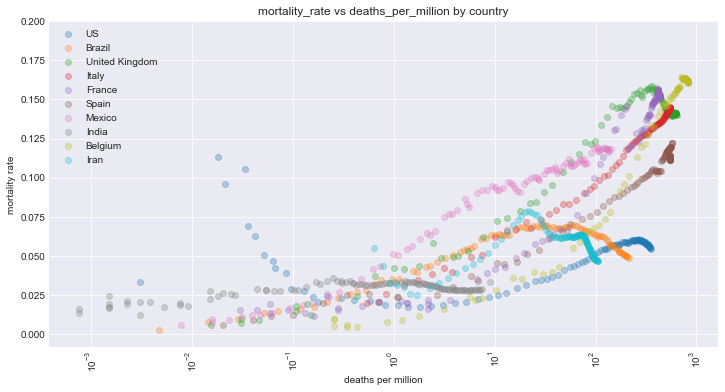

In [863]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='deaths_per_million', 
                                  y_col='mortality_rate'
                                 )

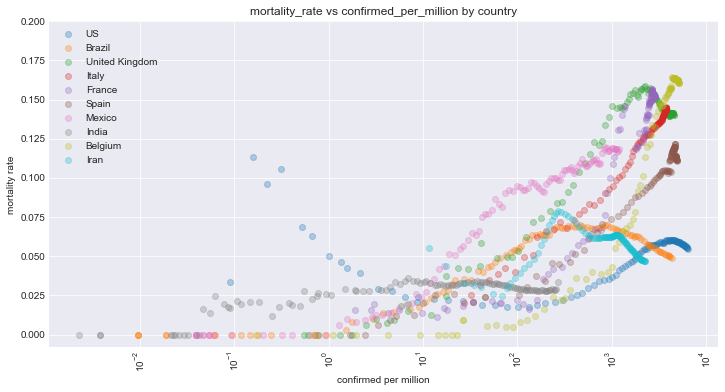

In [864]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='confirmed_per_million', 
                                  y_col='mortality_rate'
                                 )

<a id='days_behind'></a>
# How many days behind is each country from Italy?

In [865]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_pop, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

##### Days behind Italy via density of cases

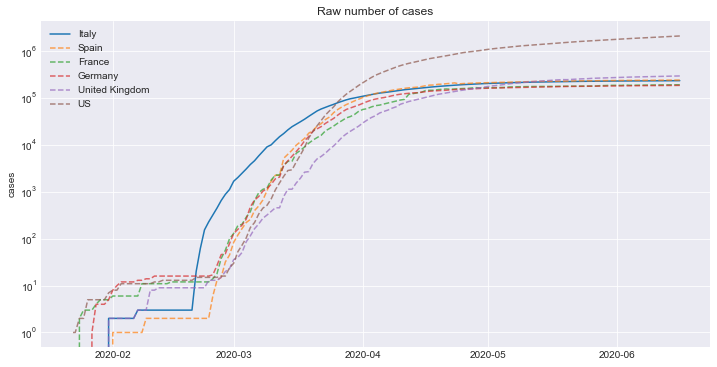

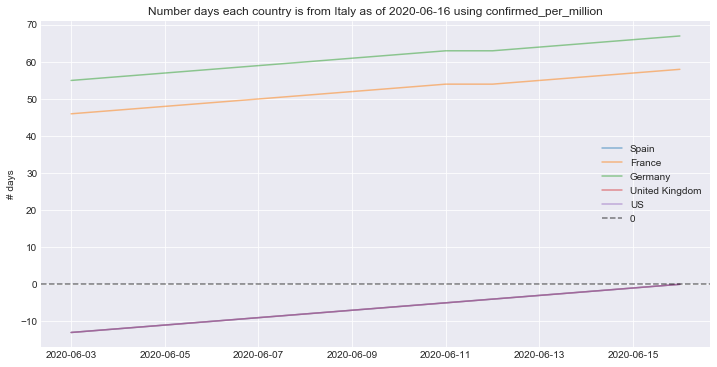

In [866]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed_per_million')

##### Days behind Italy via number of confirmed cases

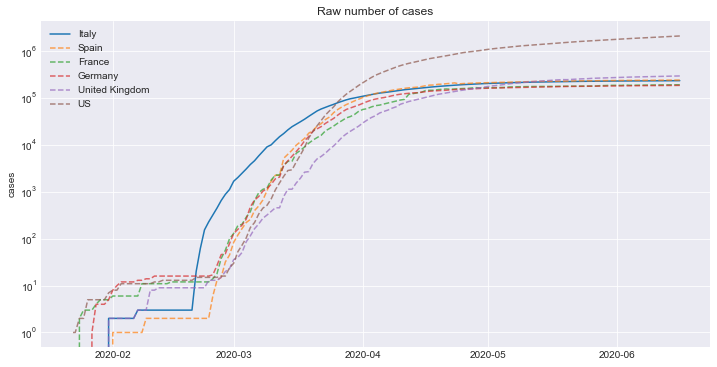

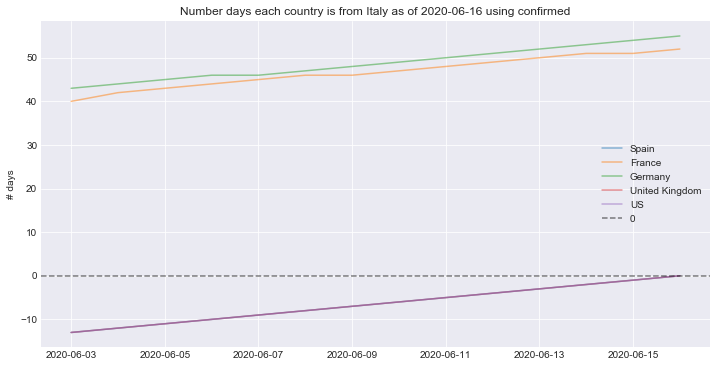

In [867]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed')

# US state breakdown

In [868]:
# load and clean data
dfp_us_raw = pd.read_csv('state_data/states-daily.csv')
dfp_us_raw = dfp_us_raw.rename(columns={'state': 'state_clean_1',
                                        'positive': 'confirmed',
                                        'death': 'deaths',
                                        'date': 'date_str'
                                       })
dfp_us_raw['date'] = dfp_us_raw['date_str'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
dfp_us_raw['country'] = 'US'

In [869]:
# load and clean data from CSSEGIS
state_base_dir = '../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'
data_paths_raw = os.listdir(state_base_dir)
data_paths = [path for path in data_paths_raw if path.endswith('csv')]
list_dfp_states = []
cols_of_interest = ['country', 'state', 'date', 'confirmed', 'deaths', 'recovered']
for path in data_paths:
    full_path = os.path.join(state_base_dir, path)
    
    # read state data
    dfp_temp = pd.read_csv(full_path)
    cols = list(dfp_temp.columns)
    
    # clean column names
    cols_translate = {'Country/Region': 'country',
                      'Province/State': 'state',
                      'Confirmed': 'confirmed',
                      'Deaths': 'deaths',
                      'Recovered': 'recovered',
                      'Country_Region': 'country',
                      'Province_State': 'state',
                      'Last_Update': 'Last Update'
                     }
    dfp_temp = dfp_temp.rename(columns=cols_translate)
    dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())
    dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
    dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
    list_dfp_states.append(dfp_temp[cols_of_interest])
dfp_us_raw = pd.concat(list_dfp_states)
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

In [870]:
# look only at the US
#dfp_us_raw = dfp[dfp['country'] == 'US'].copy()
#dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

In [871]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                #'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
#dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths_new'].fillna(0)
dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']

<a id='states_most_infections'></a>
### US states with the most new infections

In [872]:
id_cols_state = ['date', 'state']
value_cols_state = ['confirmed', 'confirmed_new', 'deaths', 'deaths_new', 'mortality_rate']

dfp_us_top_states = dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()][id_cols_state + value_cols_state]
dfp_us_top_states = dfp_us_top_states.sort_values(by='deaths', ascending=0).reset_index(drop=True)
dfp_us_top_states = dfp_us_top_states.fillna(0)
for key in value_cols_state:
    if 'rate' in key:
        continue
    dfp_us_top_states[key] = dfp_us_top_states[key].apply(int)
dfp_us_top_states.head(15)

date          state  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-06-17       New York     384575            631   30909          53   
1  2020-06-17     New Jersey     167426            323   12792          84   
2  2020-06-17  Massachusetts     105885            195    7664          17   
3  2020-06-17       Illinois     133639            623    6398          72   
4  2020-06-17   Pennsylvania      83978            389    6276          33   
5  2020-06-17       Michigan      66269            184    6034          16   
6  2020-06-17     California     158961           3235    5200          86   
7  2020-06-17    Connecticut      45349            114    4210           6   
8  2020-06-17      Louisiana      47706            534    3042          24   
9  2020-06-17        Florida      80109           2783    2993          55   
10 2020-06-17       Maryland      62409            377    2982          35   
11 2020-06-17           Ohio      42010            434    2599          24   
12 2020-06-17        Georgia      59078            664    2529          35   
13 2020-06-17        Indiana      40786            356    2447          14   
14 2020-06-17          Texas      93569           3358    2049          48   

    mortality_rate  
0         0.080372  
1         0.076404  
2         0.072380  
3         0.047875  
4         0.074734  
5         0.091053  
6         0.032712  
7         0.092836  
8         0.063766  
9         0.037362  
10        0.047782  
11        0.061866  
12        0.042808  
13        0.059996  
14        0.021898

<a id='time-series_states'></a>
### Time-series plots of infections in most-infected states

In [873]:
def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):
    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

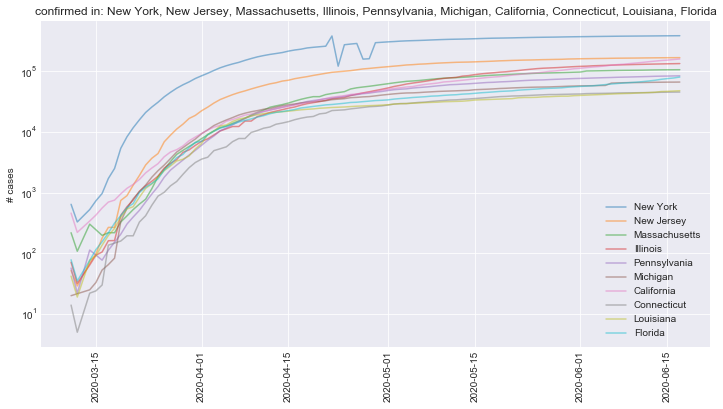

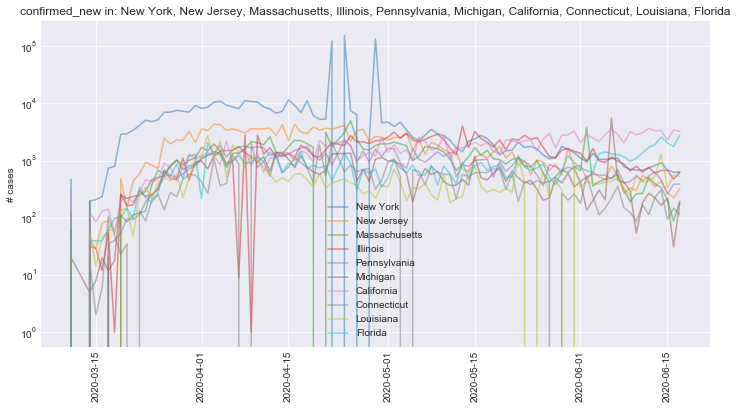

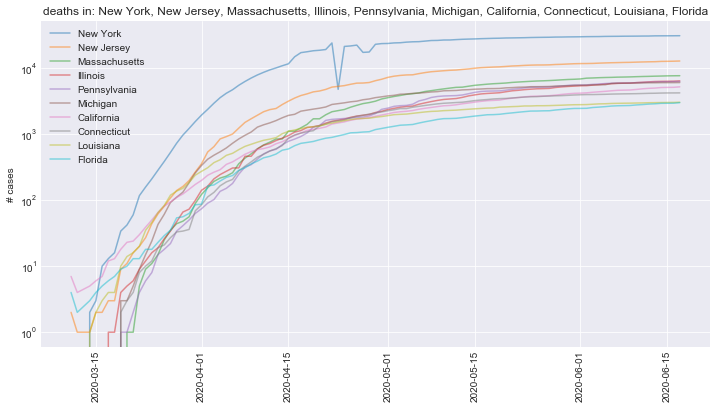

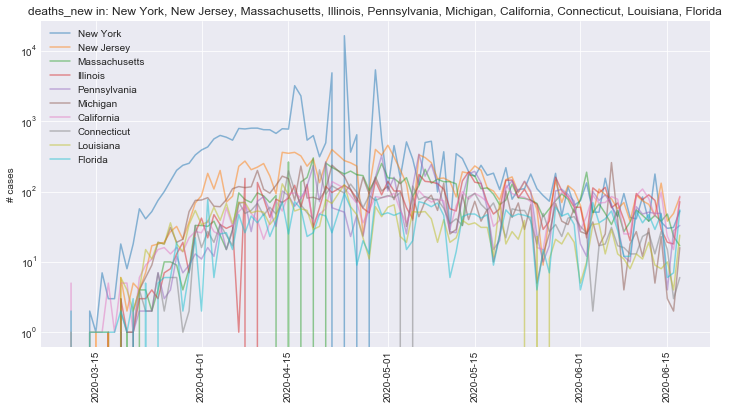

In [874]:
states_oi = dfp_us_top_states.iloc[:10]['state'].values
dt_min = datetime.datetime(2020,3,11)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths_new', date_min=dt_min)

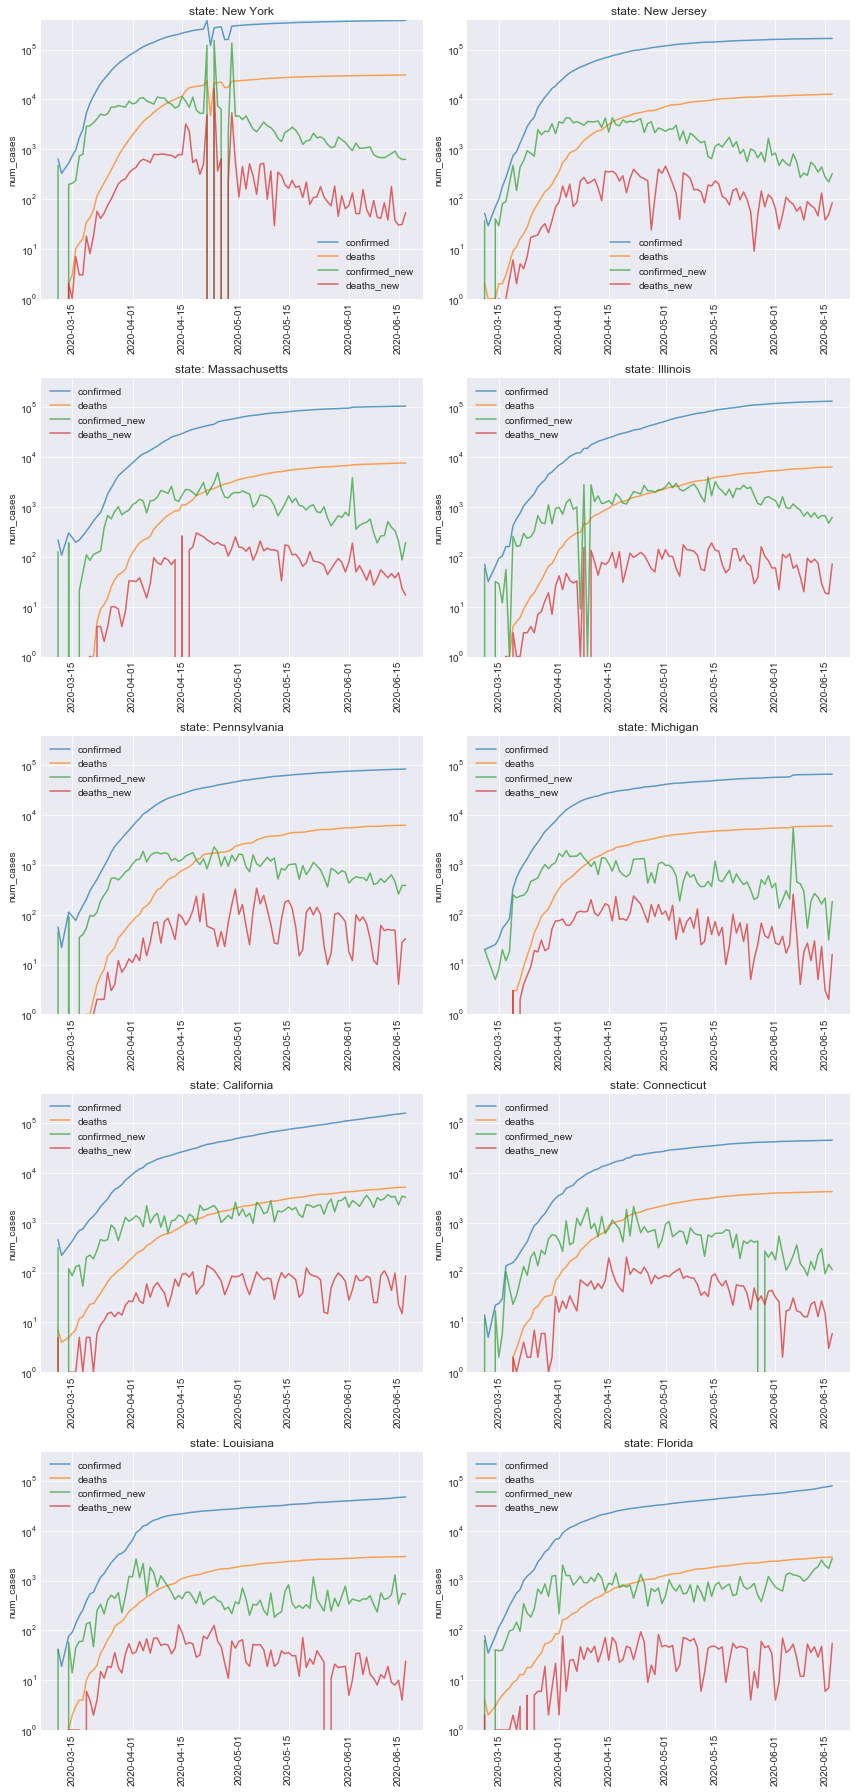

In [875]:
plot_countries(dfp_us_g, 
               countries=dfp_us_top_states.iloc[:10]['state'].values,
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

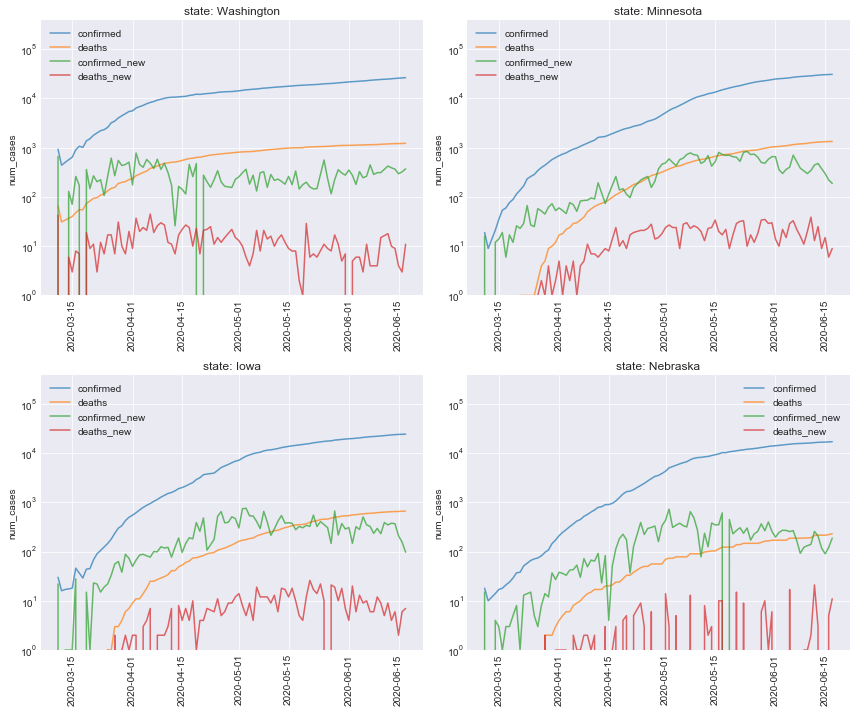

In [876]:
plot_countries(dfp_us_g, 
               countries=['Washington', 'Minnesota', 'Iowa', 'Nebraska'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

<a id='forecast_us_state'></a>
### Forecast by state

##### 1 week of data

confirmed_pred                       deaths_pred             \
date              2020-06-18 2020-06-24 2020-07-08  2020-06-18 2020-06-24   
state                                                                       
New York            385467.0   390024.0   400866.0     30998.0    31372.0   
New Jersey          167843.0   169916.0   174852.0     12864.0    13297.0   
Massachusetts       106324.0   108024.0   112096.0      7718.0     7946.0   
Illinois            134345.0   138241.0   147776.0      6445.0     6724.0   
Pennsylvania         84522.0    87235.0    93910.0      6320.0     6534.0   
Michigan             66497.0    67571.0    70145.0      6048.0     6120.0   
California          162545.0   184457.0   247767.0      5257.0     5609.0   
Connecticut          45592.0    46684.0    49334.0      4236.0     4330.0   
Louisiana            48533.0    52808.0    64303.0      3047.0     3113.0   
Florida              82271.0    97826.0   146534.0      3019.0     3206.0   

                         mortality_rate_pred                        \
date          2020-07-08          2020-06-18 2020-06-24 2020-07-08   
state                                                                
New York         32263.0            0.080417   0.080436   0.080483   
New Jersey       14366.0            0.076643   0.078256   0.082161   
Massachusetts     8503.0            0.072589   0.073558   0.075855   
Illinois          7425.0            0.047974   0.048640   0.050245   
Pennsylvania      7059.0            0.074773   0.074901   0.075168   
Michigan          6290.0            0.090951   0.090571   0.089671   
California        6524.0            0.032342   0.030408   0.026331   
Connecticut       4559.0            0.092911   0.092751   0.092411   
Louisiana         3274.0            0.062782   0.058949   0.050915   
Florida           3687.0            0.036696   0.032772   0.025161   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.001961             0.002001  
New Jersey                   0.002048             0.005537  
Massachusetts                0.002647             0.004856  
Illinois                     0.004776             0.007106  
Pennsylvania                 0.005280             0.005541  
Michigan                     0.002673             0.001961  
California                   0.021300             0.010853  
Connecticut                  0.003952             0.003673  
Louisiana                    0.014167             0.003596  
Florida                      0.029282             0.010040

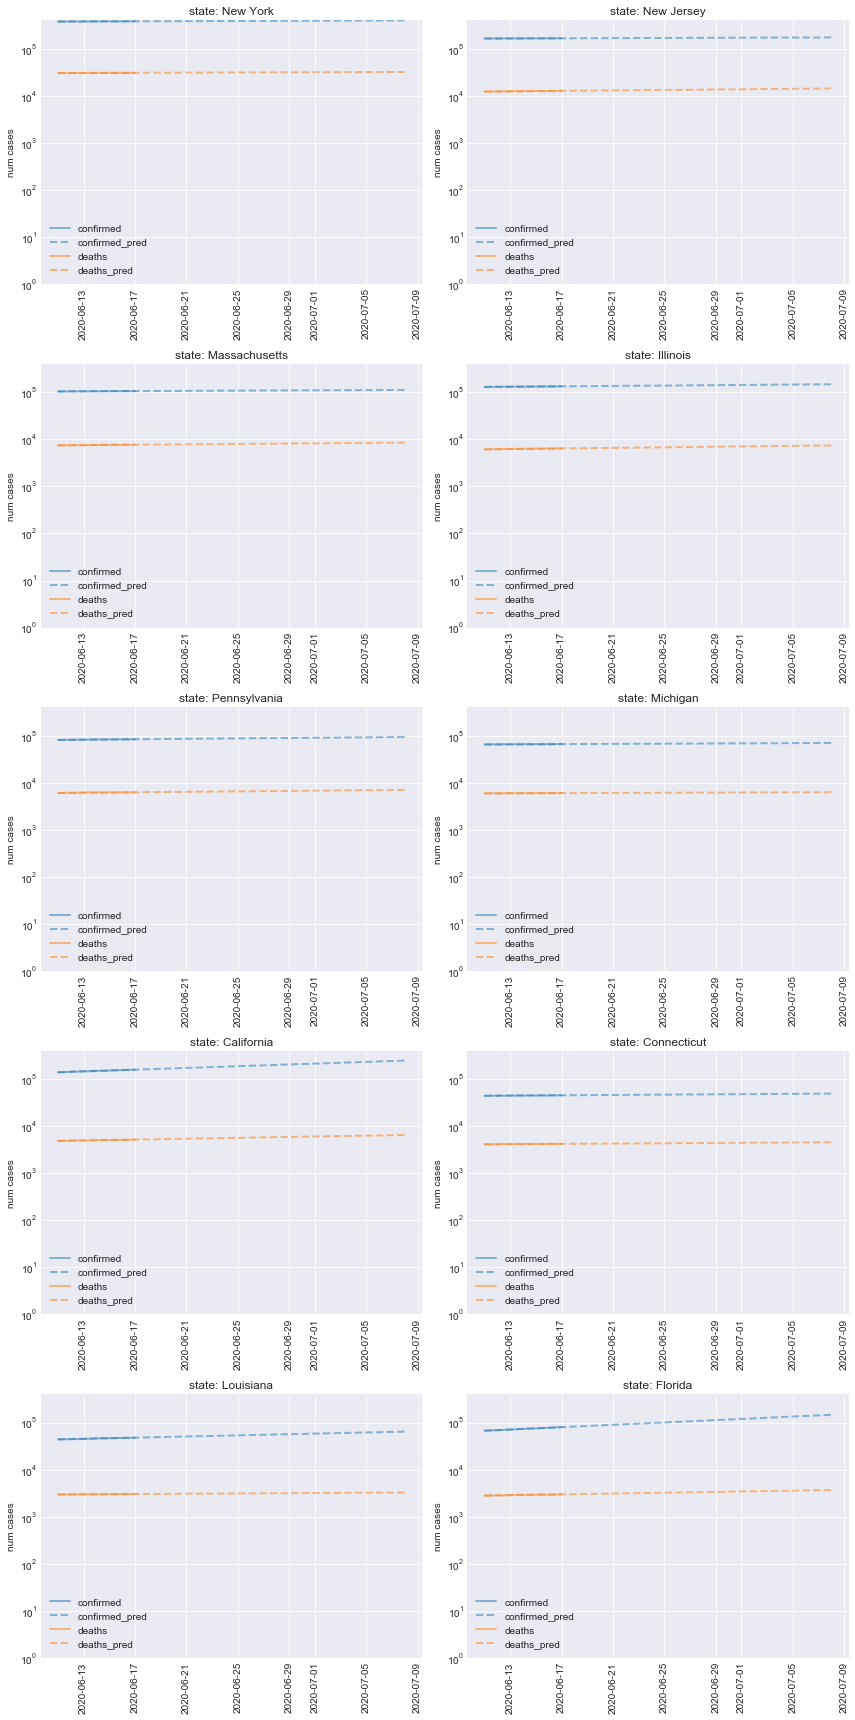

In [877]:
dfp_state_recent_1, dfp_state_forecasts_out_1 = fit_exp(dfp_us_g, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_1, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

##### 2 weeks of data

confirmed_pred                       deaths_pred             \
date              2020-06-18 2020-06-24 2020-07-08  2020-06-18 2020-06-24   
state                                                                       
New York            385702.0   390551.0   402102.0     31021.0    31432.0   
New Jersey          168122.0   170633.0   176637.0     12867.0    13306.0   
Massachusetts       106557.0   108612.0   113560.0      7737.0     7997.0   
Illinois            134906.0   139640.0   151343.0      6506.0     6899.0   
Pennsylvania         84750.0    87839.0    95491.0      6343.0     6596.0   
Michigan             68235.0    71654.0    80314.0      6136.0     6328.0   
California          163092.0   186100.0   253210.0      5302.0     5746.0   
Connecticut          45604.0    46691.0    49330.0      4246.0     4358.0   
Louisiana            48047.0    51468.0    60428.0      3055.0     3132.0   
Florida              80469.0    92395.0   127557.0      3035.0     3253.0   

                         mortality_rate_pred                        \
date          2020-07-08          2020-06-18 2020-06-24 2020-07-08   
state                                                                
New York         32413.0            0.080427   0.080481   0.080609   
New Jersey       14389.0            0.076534   0.077980   0.081461   
Massachusetts     8640.0            0.072609   0.073629   0.076083   
Illinois          7912.0            0.048226   0.049406   0.052279   
Pennsylvania      7227.0            0.074844   0.075092   0.075683   
Michigan          6801.0            0.089925   0.088313   0.084680   
California        6932.0            0.032509   0.030876   0.027376   
Connecticut       4629.0            0.093106   0.093337   0.093837   
Louisiana         3321.0            0.063584   0.060853   0.054958   
Florida           3824.0            0.037716   0.035208   0.029979   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.002084             0.002198  
New Jersey                   0.002473             0.005608  
Massachusetts                0.003187             0.005539  
Illinois                     0.005765             0.009824  
Pennsylvania                 0.005984             0.006544  
Michigan                     0.008183             0.005160  
California                   0.022239             0.013486  
Connecticut                  0.003935             0.004329  
Louisiana                    0.011529             0.004195  
Florida                      0.023302             0.011622

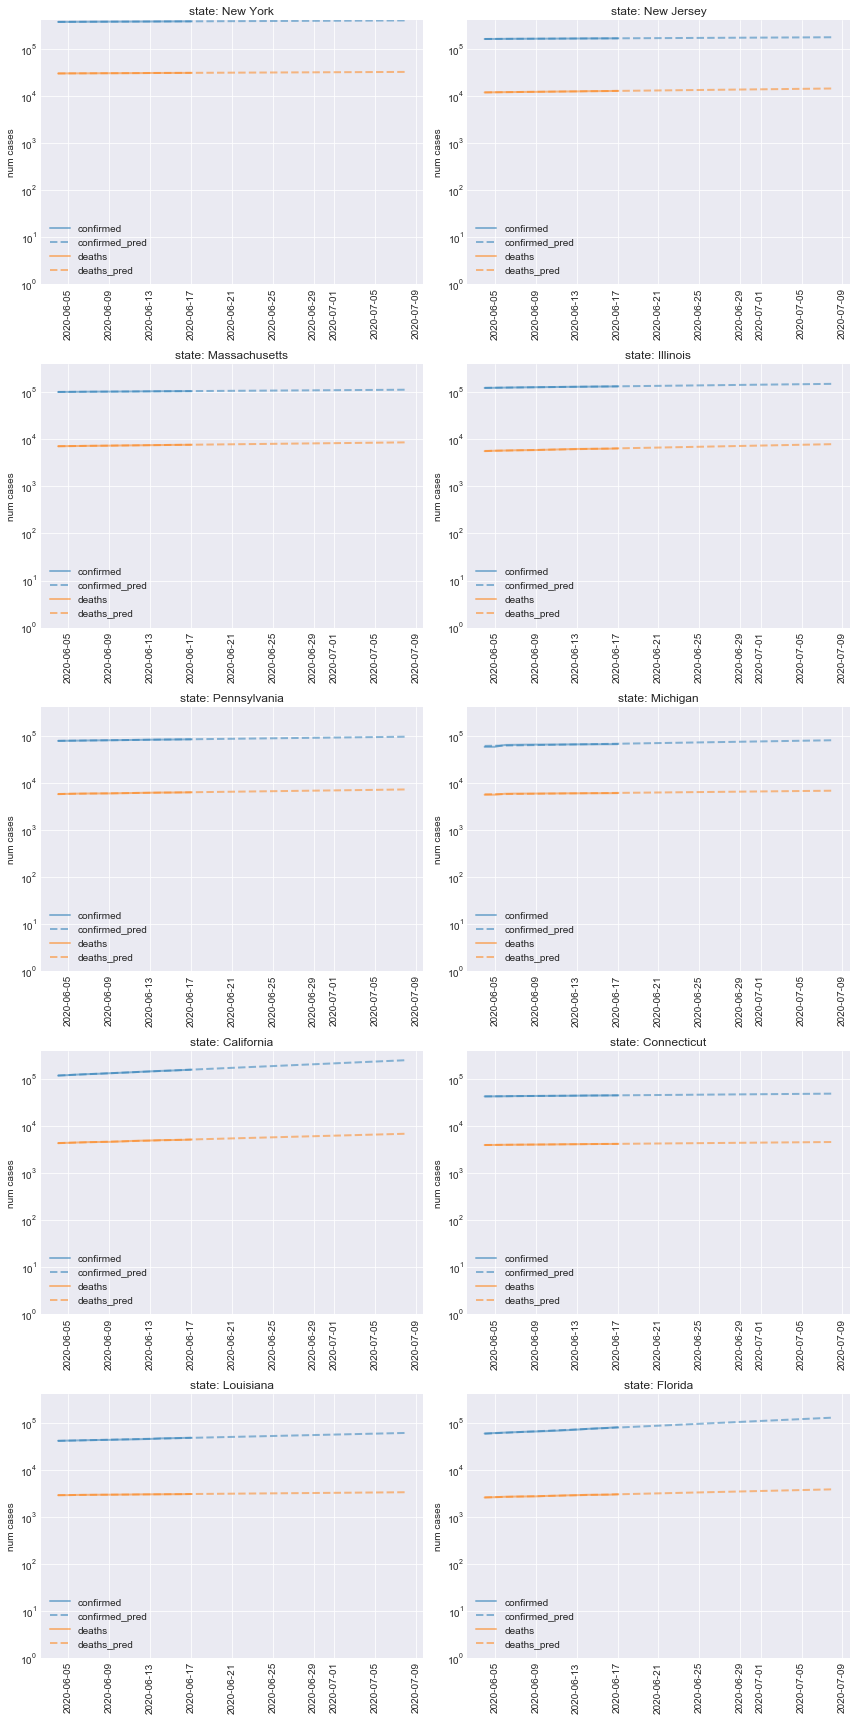

In [878]:
dfp_state_recent_2, dfp_state_forecasts_out_2 = fit_exp(dfp_us_g, 
                                                    n_days_predict=14,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_2, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

<a id='us_state_daily_increase_fraction'></a>
##### States and their daily increase fraction in confirmed cases/deaths
Computed via linear fit of the log of the confirmed cases/deaths over the last 7 days.

In [879]:
# increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
# curr_cols = ['date', 'state', 'confirmed', 'deaths']
# dfp_state_increase_m = dfp_us_g_latest[curr_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
# for col in ['confirmed', 'deaths']:
#     dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)

In [880]:
# latest date
dt_latest = dfp_us_g['date'].max()
dfp_us_g_date_max = dfp_us_g.groupby(['state'], as_index=False).agg({'date': np.max})
#dfp_us_g_latest = dfp_us_g[dfp_us_g['date'] == dt_latest].copy()
dfp_us_g_latest = dfp_us_g.merge(dfp_us_g_date_max, on=['state', 'date'], how='inner')

# what is the distribution in % increase in deaths?
dfp_state_increase = (dfp_state_forecasts_out_1[(dfp_state_forecasts_out_1['date'] == dfp_state_forecasts_out_1['date'].max()) &
                                                (dfp_state_forecasts_out_1['deaths_pred'] > 2)
                                               ].
                      sort_values(by='frac_increase_deaths', ascending=0).
                      reset_index(drop=True)
                     )
increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
curr_cols = ['date', 'state']
int_cols = ['confirmed', 'deaths', 'deaths_new']
float_cols = ['frac_increase_confirmed', 'frac_increase_deaths']
dfp_state_increase_m = dfp_us_g_latest[curr_cols + int_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
for col in int_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)
for col in float_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(lambda x: np.round(float(x),3))
(dfp_state_increase_m[curr_cols + int_cols + float_cols].
 sort_values(by='frac_increase_deaths', ascending=0).
 reset_index(drop=True)
)


date                 state  confirmed  deaths  deaths_new  \
0  2020-06-17              Nebraska      17038     231          11   
1  2020-06-17                  Utah      14937     145           2   
2  2020-06-17             Tennessee      31751     493          11   
3  2020-06-17              Arkansas      13191     188           6   
4  2020-06-17               Arizona      39185    1228          25   
5  2020-06-17                Alaska        675      12           0   
6  2020-06-17          South Dakota       5966      77           2   
7  2020-06-17            New Mexico       9933     447           7   
8  2020-06-17               Georgia      59078    2529          35   
9  2020-06-17               Montana        614      19           0   
10 2020-06-17         New Hampshire       5364     326           6   
11 2020-06-17                Oregon       6098     182           2   
12 2020-06-17            California     158961    5200          86   
13 2020-06-17                 Texas      93569    2049          48   
14 2020-06-17               Florida      80109    2993          55   
15 2020-06-17             Minnesota      30882    1344           9   
16 2020-06-17        North Carolina      45907    1169          29   
17 2020-06-17          Rhode Island      16164     865          14   
18 2020-06-17                  Ohio      42010    2599          24   
19 2020-06-17               Alabama      26912     785          11   
20 2020-06-17           Mississippi      20152     915          20   
21 2020-06-17                  Iowa      24179     665           7   
22 2020-06-17        South Carolina      19990     607           5   
23 2020-06-17              Illinois     133639    6398          72   
24 2020-06-17  District of Columbia       9818     520           5   
25 2020-06-17            Washington      26531    1231          11   
26 2020-06-17              Missouri      16857     891           4   
27 2020-06-17              Maryland      62409    2982          35   
28 2020-06-17               Indiana      40786    2447          14   
29 2020-06-17          Pennsylvania      83978    6276          33   
30 2020-06-17             Wisconsin      23198     703           9   
31 2020-06-17              Virginia      55331    1570          18   
32 2020-06-17            New Jersey     167426   12792          84   
33 2020-06-17              Kentucky      12647     505           0   
34 2020-06-17              Delaware      10403     424           1   
35 2020-06-17         Massachusetts     105885    7664          17   
36 2020-06-17         West Virginia       2341      88           0   
37 2020-06-17                 Idaho       3462      88           1   
38 2020-06-17                Nevada      11683     467           2   
39 2020-06-17           Puerto Rico       5951     147           0   
40 2020-06-17              Colorado      29427    1617          12   
41 2020-06-17           Connecticut      45349    4210           6   
42 2020-06-17             Louisiana      47706    3042          24   
43 2020-06-17                Kansas      11411     246           0   
44 2020-06-17              Michigan      66269    6034          16   
45 2020-06-17              Oklahoma       8645     363           4   
46 2020-06-17                 Maine       2819     101           0   
47 2020-06-17              New York     384575   30909          53   
48 2020-06-17          North Dakota       3124      74           0   
49 2020-06-17                  Guam        186       5           0   
50 2020-06-17                Hawaii        736      17           0   
51 2020-06-17        Virgin Islands         72       6           0   
52 2020-06-17               Vermont       1131      55           0   
53 2020-06-17               Wyoming       1089      18           0   

    frac_increase_confirmed  frac_increase_deaths  
0                     0.009                 0.023  
1                     0.025                 0.020  
2 

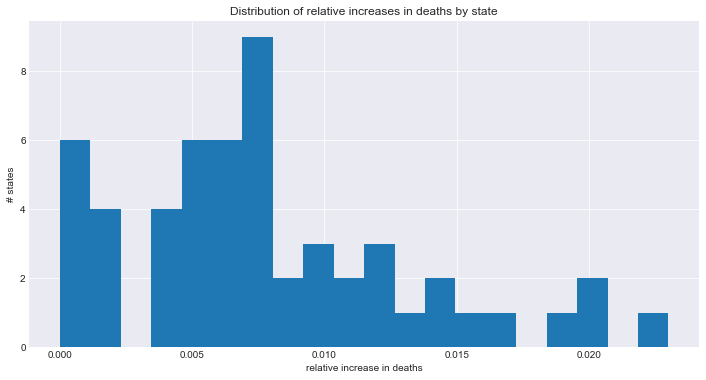

In [881]:
dfp_state_increase_m['frac_increase_deaths'].hist(bins=20)
plt.xlabel('relative increase in deaths')
plt.ylabel('# states')
plt.title('Distribution of relative increases in deaths by state')
plt.show()

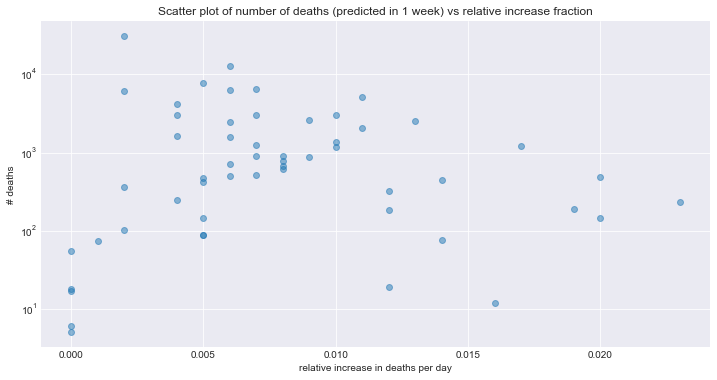

In [882]:
plt.plot(dfp_state_increase_m['frac_increase_deaths'], dfp_state_increase_m['deaths'], 'o', alpha=0.5)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('relative increase in deaths per day')
plt.ylabel('# deaths')
plt.title('Scatter plot of number of deaths (predicted in 1 week) vs relative increase fraction')
plt.show()

<a id='state_infections_vs_wa'></a>
##### Compare US state infections against Washington

In [883]:
dfp_us_g = dfp_us_g[~(dfp_us_g['date']==datetime.datetime(2020,3,9))]

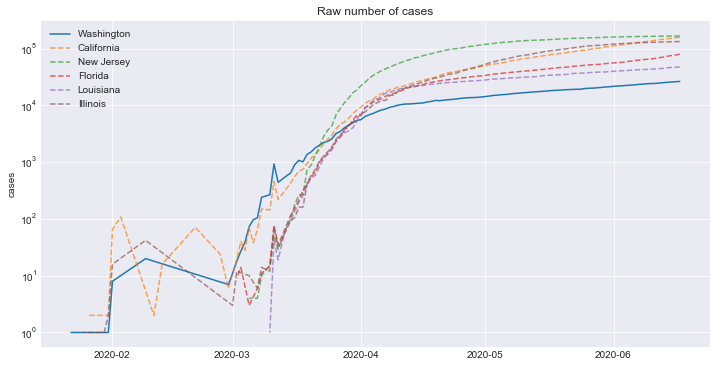

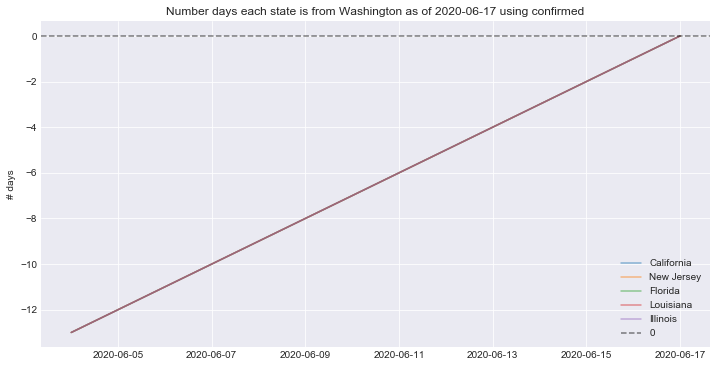

In [884]:
_ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'Washington', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='state_infections_vs_ny'></a>
##### Compare US state infections against New York

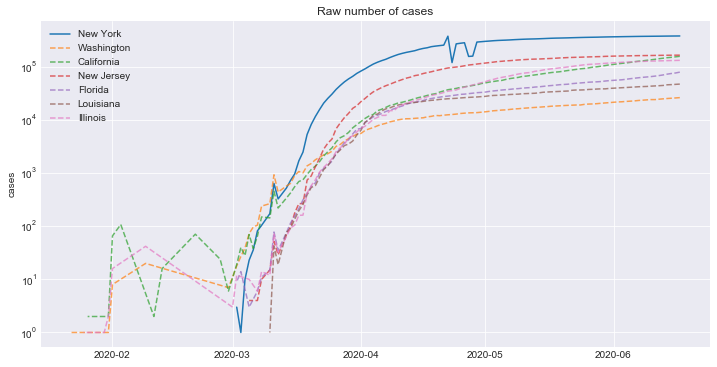

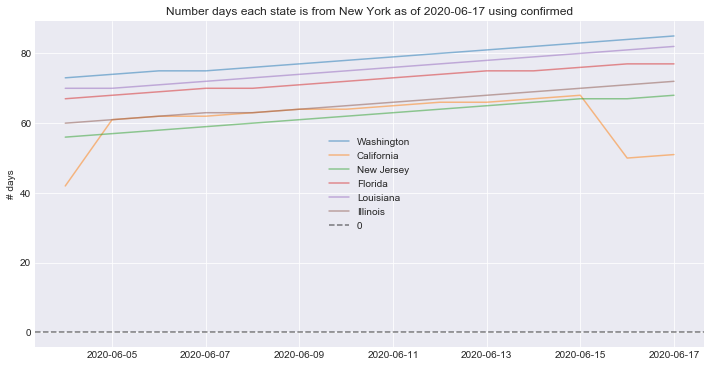

In [885]:
_ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'New York', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='mortality_by_us_state'></a>
### Mortality rate by US state

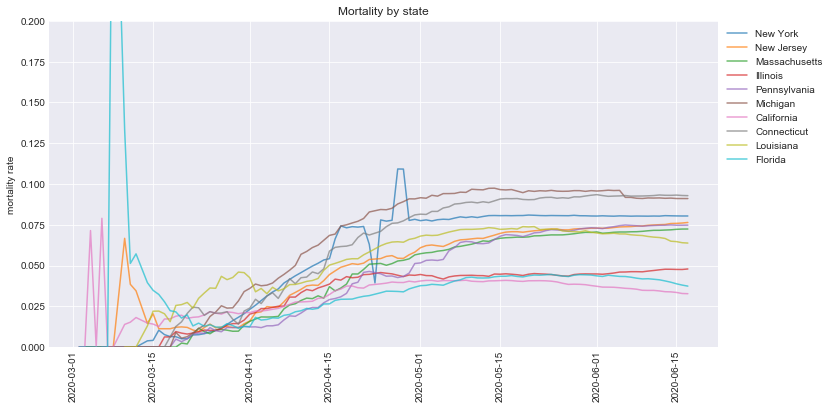

In [886]:
n_states = 10
states = dfp_us_top_states.iloc[:n_states]['state']

plot_mortality_rate(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,2))

##### Relationship between mortality rate and number of cases

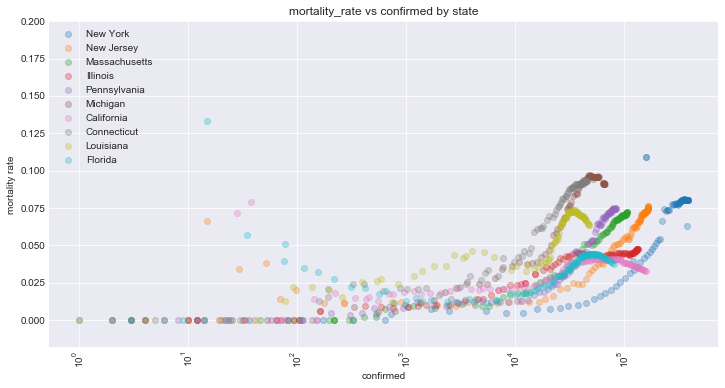

In [887]:
plot_mortality_rate_vs_infections(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))

<a id='us_state_relative_increases'></a>
### Relative increases per day by state

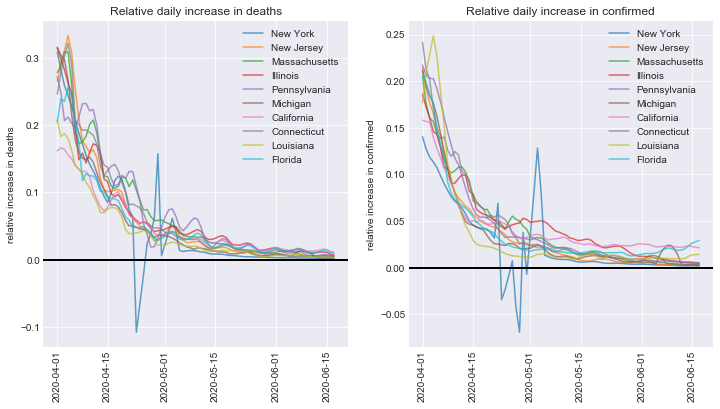

In [888]:
find_relative_increase_data_and_plot(dfp_us_g, n_locales=10, col_locale='state', dt=datetime.datetime(2020,4,1))


<a id='us_state_0_new'></a>
# When will each state hit 0 new deaths/confirmed? 

In [889]:
def fit_exp_new(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False,
            fit_cols=['confirmed_new', 'deaths_new']
           ):
    
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    median_funcs = {}
    log_cols = []
    for col in fit_cols:
        log_col = f'{col}_log'
        dfp_country_recent[log_col] = dfp_country_recent[col].apply(lambda x: np.log10(x) if x > 1 else None)
        median_funcs[log_col] = np.nanmedian
        log_cols.append(log_col)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    # fill in the missing data with the median
    dfp_country_medians = dfp_country_recent.groupby(col_locale, as_index=False).agg(median_funcs).fillna(0)
    null_countries = list(dfp_country_recent[dfp_country_recent.isnull().any(axis=1)][col_locale].unique())
#     print(f"{col_locale}s with nulls: {','.join(null_countries)}")
#     display(dfp_country_medians.sample(n=5))
#     print(log_cols)
    for col in log_cols:
        for country in null_countries:
            val = dfp_country_medians[dfp_country_medians[col_locale] == country][col].values[0]
            #print(f"country={country}, median value={val:0.5f}")
            dfp_country_recent.loc[(dfp_country_recent[col_locale] == country) & (dfp_country_recent[col].isnull()), col] = val
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n, cols_to_be_null_in_future=fit_cols)
        list_dfp_recent.append(dfp_most_recent_tmp)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    
    for col in fit_cols:
        dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                               col_fit=f'{col}_log', 
                                                               col_pred=f'{col}_pred', 
                                                               col_locale=col_locale, 
                                                               date_most_recent=date_most_recent
                                                              )
    #dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    frac_cols = [col for col in dfp_forecasts.columns if 'frac_increase' in col]
    pred_cols = [col for col in dfp_forecasts.columns if '_pred' in col]
    id_cols = ['date', col_locale]
    dfp_forecasts_out = dfp_forecasts[id_cols + pred_cols + frac_cols].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({x: np.mean for x in frac_cols}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=pred_cols  #'mortality_rate_pred'
                                                 ).sort_values(by=(pred_cols[0], dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts_new(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                       top_countries=None,
                       cols_to_pred=['confirmed_new', 'deaths_new'],
                       cols_deaths='deaths_new',
                  ):
    # subset the top countries
    death_cols = [col for col in cols_to_pred if 'deaths' in col]
    dfp_non_pred = dfp_country_recent.dropna(subset=[death_cols[0]])
    dt_max = dfp_non_pred['date'].max()
    
    if top_countries is None:
        dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                             sort_values(by=death_cols[0], ascending=0).
                             iloc[:n_countries]
                            )
        top_countries = (dfp_top_countries.
                         iloc[:n_countries][col_locale].values
                        )
    else:
        n_countries = len(top_countries)
        
    dfp_country_recent = dfp_country_recent[dfp_country_recent[col_locale].isin(top_countries)]

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    
    y_max = 1
    pred_cols = [x + '_pred' for x in cols_to_pred]
    for col in cols_to_pred:
        y_max = max(dfp_country_recent[col].max(), y_max)
    y_min = 1

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        
        # find total deaths
        dfp_plot_calcs = dfp_plot.dropna(subset={cols_deaths})
        dfp_plot_latest = dfp_plot_calcs[dfp_plot_calcs['date'] == dfp_plot_calcs['date'].max()]
        x = 1 + dfp_plot_calcs['frac_increase_deaths'].mean()
        n_days = (dfp_country_recent['date'].max() - dfp_plot_calcs['date'].max()).days
        multiplier = (x**n_days - 1) / (x - 1)
        curr_deaths_new = dfp_plot_latest[f'{cols_deaths}_pred'].values[0]
        curr_deaths_total = dfp_plot_latest['deaths'].values[0]
        n_deaths_pred = curr_deaths_new * multiplier + curr_deaths_total
        
        
        plt.subplot(n_rows, n_columns, i)
        for key in cols_to_pred:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}, pred_tot_deaths = {n_deaths_pred:0.0f}, curr_deaths = {curr_deaths_total:0.0f}, x={x:0.3f}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast_new(dfp_forecasts_out, dfp_country_recent, col_locale='state', n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"new_cases_covid-19_{col_locale}_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

In [890]:
n_days_training = 21
dfp_us_g['deaths_new_smooth'] = dfp_us_g.groupby(['country', 'state'], as_index=False)['deaths_new'].rolling(7).mean().reset_index(0,drop=True)
dfp_us_g['confirmed_new_smooth'] = dfp_us_g.groupby(['country', 'state'], as_index=False)['confirmed_new'].rolling(7).mean().reset_index(0,drop=True)
dfp_us_recent_1, dfp_forecasts_us_out_1 = fit_exp_new(dfp_us_g, 
                                                    n_days_predict=n_days_training,
                                                    n_days_into_future=[1,7,2*7,4*7,8*7,12*7,16*7,20*7,24*7,32*7], 
                                                    col_locale='state', 
                                                    top_countries=None,
                                                      fit_cols=['confirmed_new_smooth', 'deaths_new_smooth'],
                                                   )

confirmed_new_smooth_pred                                   \
date                         2020-06-18 2020-06-24 2020-07-01 2020-07-15   
state                                                                      
California                         3260       3609       4063       5150   
Florida                            1874       2567       3705       7719   
New York                            673        526        395        223   
Illinois                            587        418        281        127   
Louisiana                           538        617        724        997   
Pennsylvania                        433        374        315        223   
Michigan                            389        359        327        271   
New Jersey                          335        245        170         82   
Massachusetts                       299        208        137         59   
Connecticut                         147        117         90         53   

                                                                      \
date          2020-08-12 2020-09-09 2020-10-07 2020-11-04 2020-12-02   
state                                                                  
California          8274      13291      21351      34300      55100   
Florida            33502     145399     631029    2738656   11885708   
New York              70         22          7          2          0   
Illinois              26          5          1          0          0   
Louisiana           1891       3585       6797      12888      24435   
Pennsylvania         112         56         28         14          7   
Michigan             186        128         88         60         41   
New Jersey            19          4          1          0          0   
Massachusetts         11          2          0          0          0   
Connecticut           18          6          2          0          0   

                         deaths_new_smooth_pred                        \
date          2021-01-27             2020-06-18 2020-06-24 2020-07-01   
state                                                                   
California        142192                     68         71         74   
Florida        223872243                     34         34         35   
New York               0                     58         48         39   
Illinois               0                     58         51         45   
Louisiana          87836                     12         11         10   
Pennsylvania           1                     36         29         23   
Michigan              19                     23         18         14   
New Jersey             0                     66         62         57   
Massachusetts          0                     37         29         22   
Connecticut            0                     14         10          7   

                                                                      \
date          2020-07-15 2020-08-12 2020-09-09 2020-10-07 2020-11-04   
state                                                                  
California            81         97        116        138        165   
Florida               36         38         40         43         45   
New York              25         10          4          1          0   
Illinois              35         20         12          7          4   
Louisiana              7          4          2          1          0   
Pennsylvania          14          5          2          0          0   
Michigan               8          3          1          0          0   
New Jersey            50         37         28         21         15   
Massachusetts         13          4          1          0          0   
Connecticut            4          1          0          0          0   

                                    frac_increase_confirmed  \
date          2020-12-02 2021-01-27                           
state                                                         
California  

In [891]:
#dfp_us_recent_1[dfp_us_recent_1.date == '2020-05-29'].sort_values(by='deaths_new_pred', ascending=0).reset_index(drop=True)

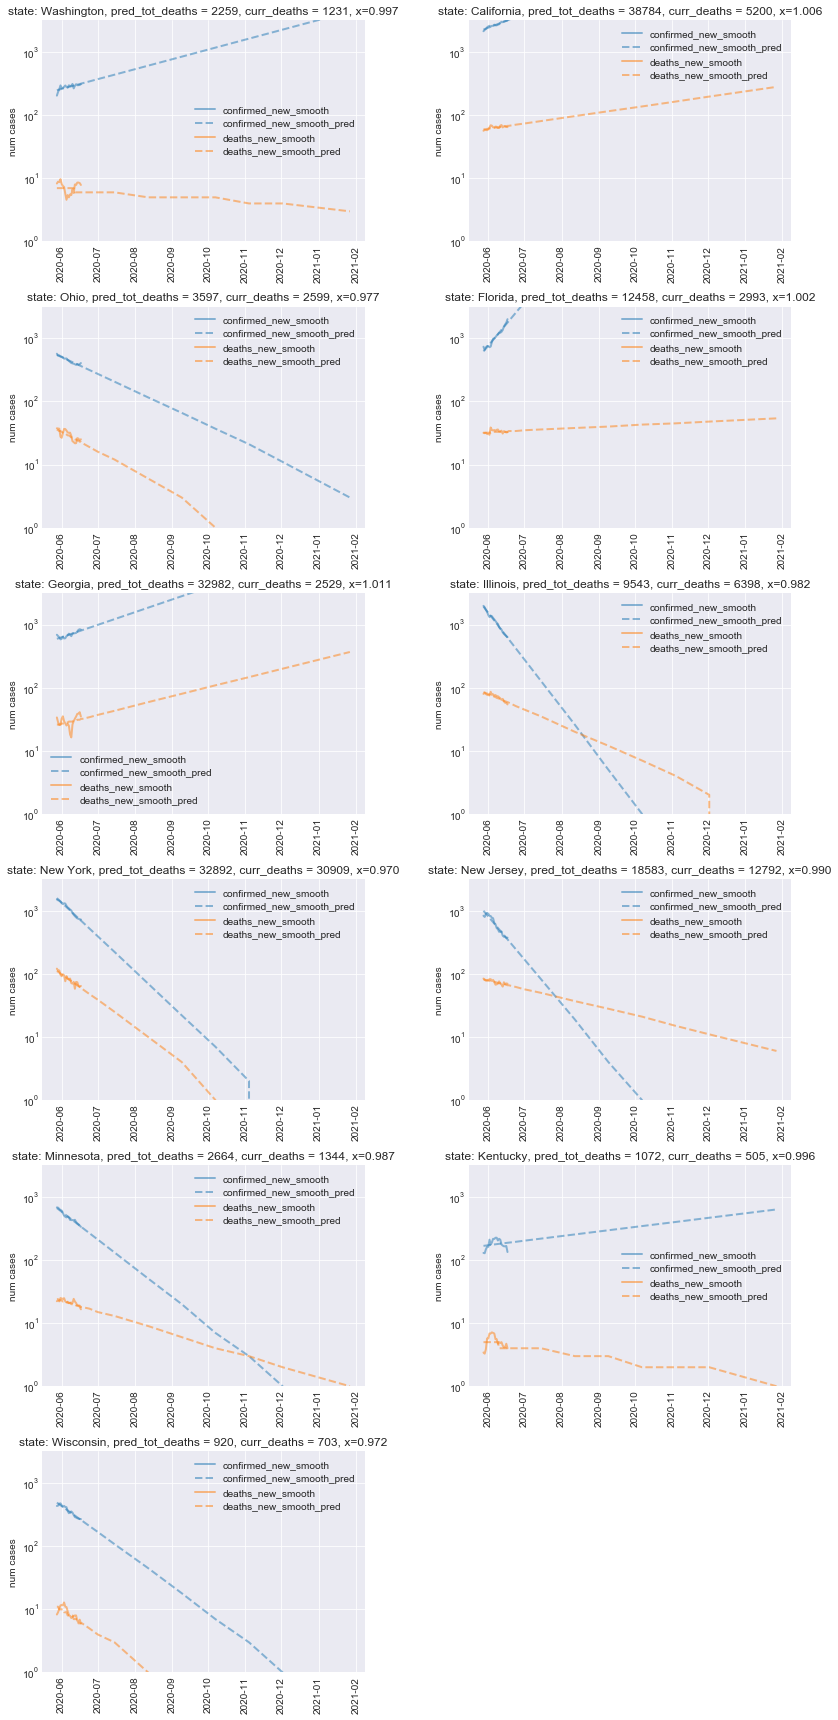

In [892]:
plot_forecasts_new(
    dfp_us_recent_1, 
    col_locale='state', 
    top_countries=['Washington', 'California', 'Ohio', 'Florida', 'Georgia', 'Illinois', 'New York', 'New Jersey', 'Minnesota', 'Kentucky', 'Wisconsin'],
    cols_to_pred=['confirmed_new_smooth', 'deaths_new_smooth'],
    cols_deaths='deaths_new_smooth',
)

In [893]:
save_forecast_new(dfp_forecasts_us_out_1, dfp_us_recent_1, 'state', n_days_training=n_days_training)

saved forecast to predictions/new_cases_covid-19_state_forecast_from_2020-06-17_n_days_training=21.csv


<a id='us_state_smoothed_trend'></a>
### Plot trends

In [894]:
dfp_us_g_new_confirmed = dfp_us_g[dfp_us_g['date'] > datetime.datetime(2020,4,1)].groupby('state', as_index=False).agg({'confirmed_new': np.sum})
states_minimum_thresh = dfp_us_g_new_confirmed[(dfp_us_g_new_confirmed['confirmed_new'] > 100)].state

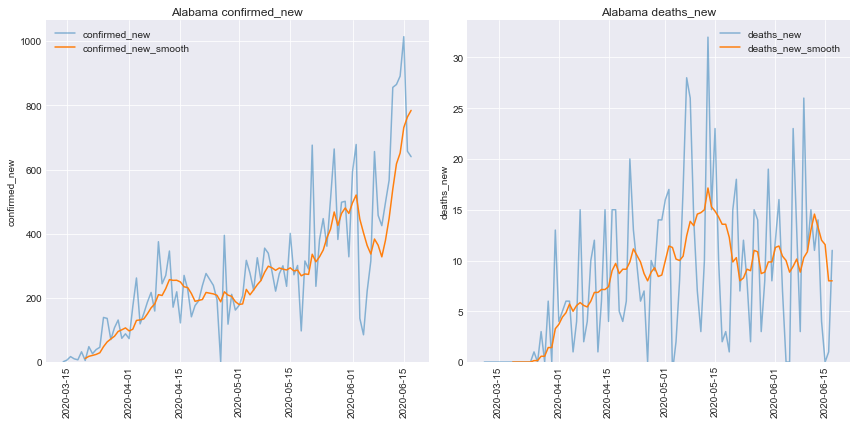

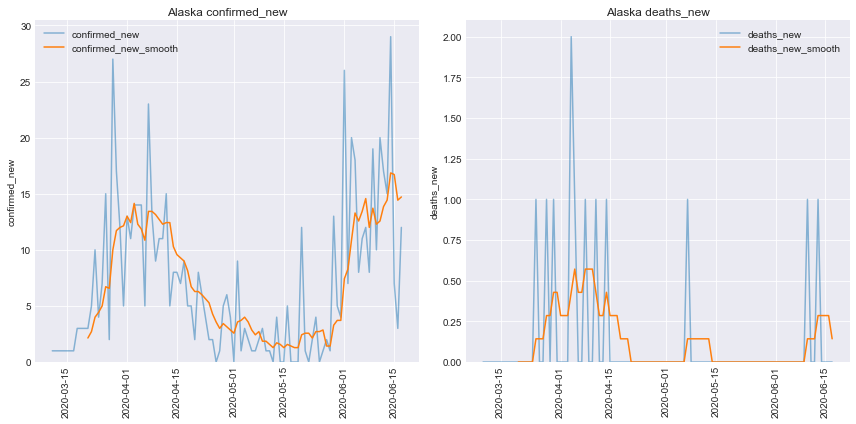

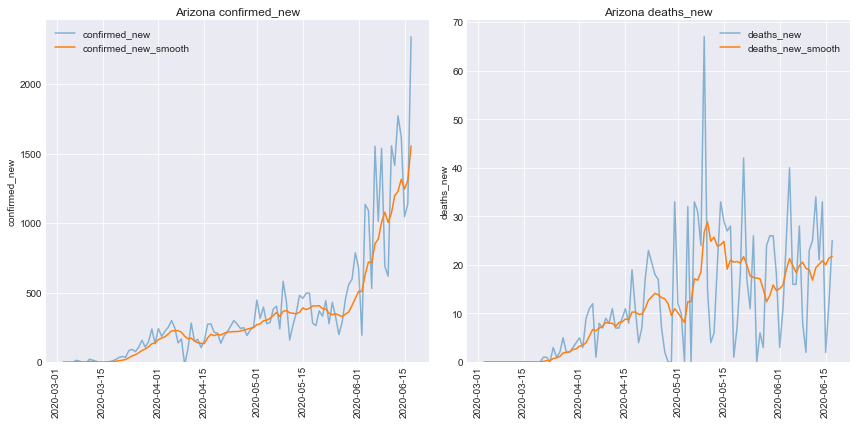

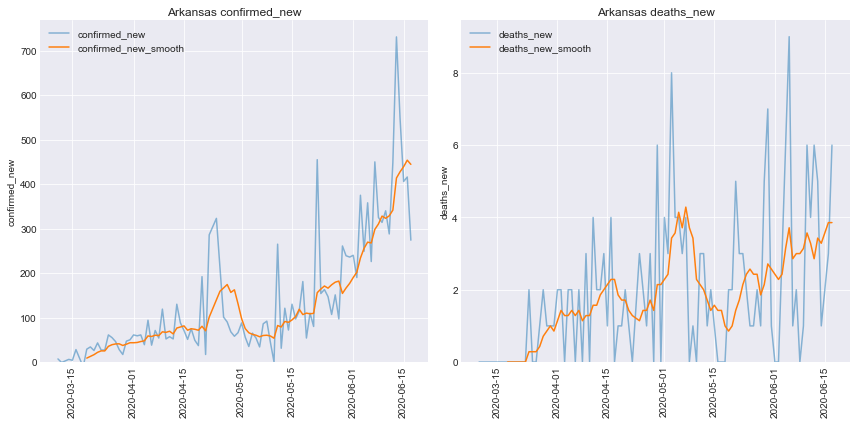

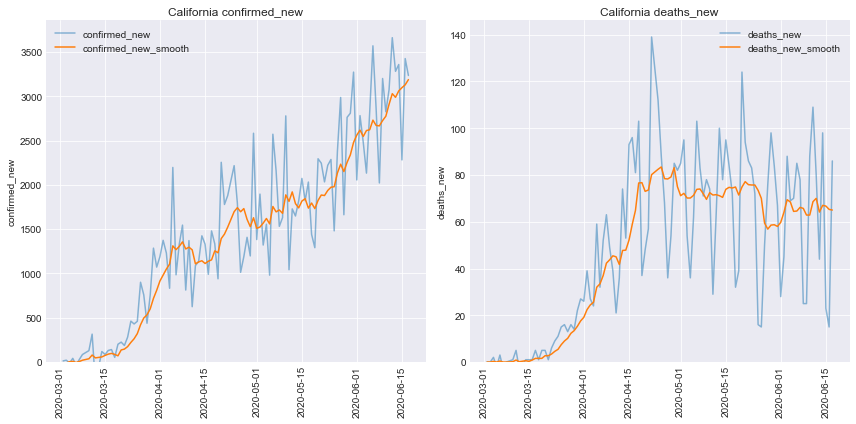

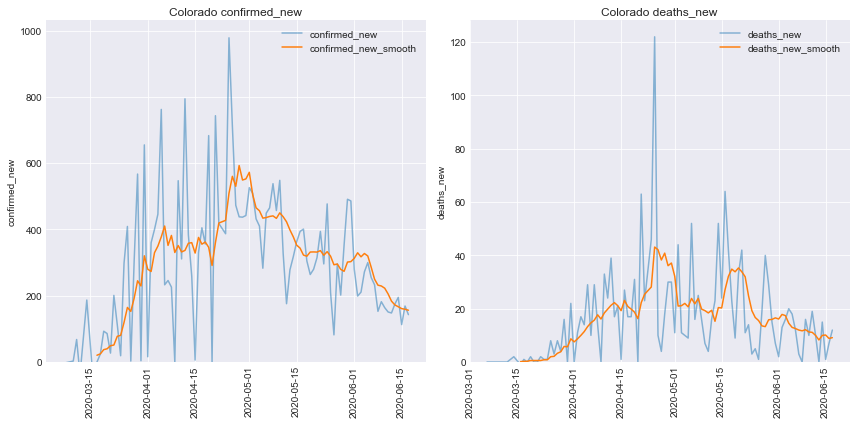

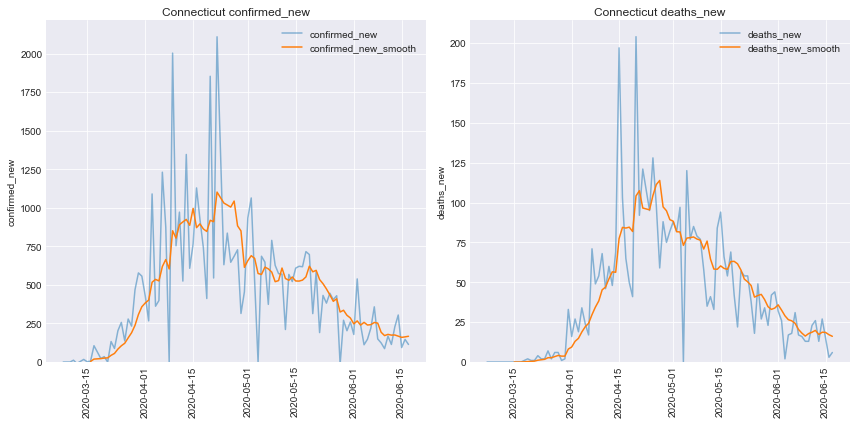

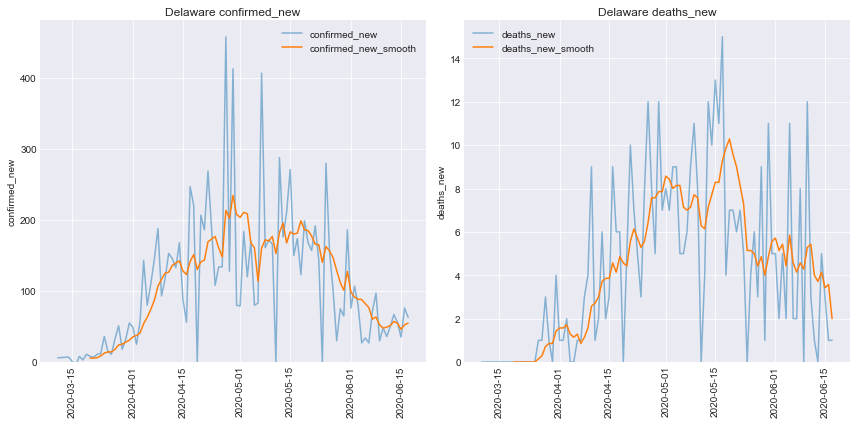

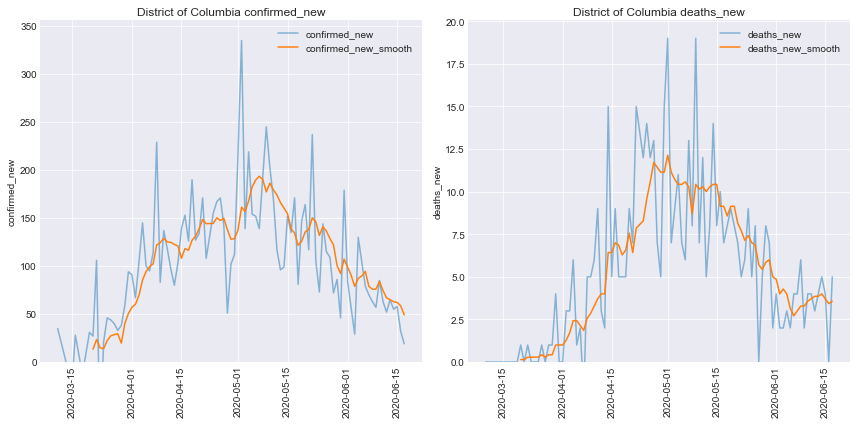

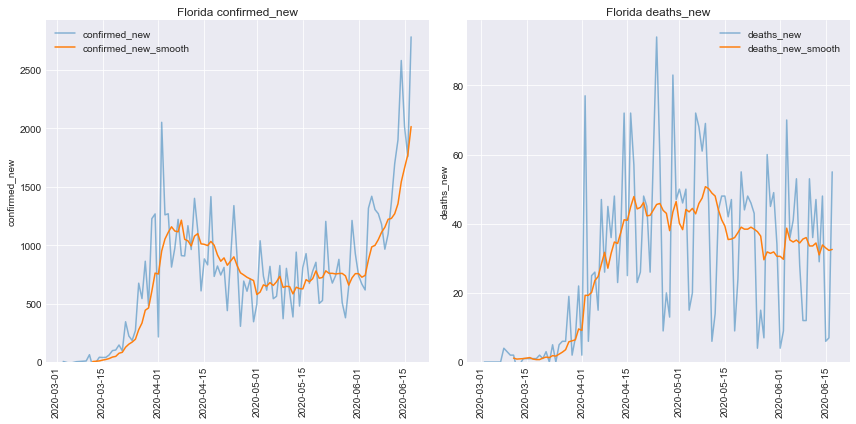

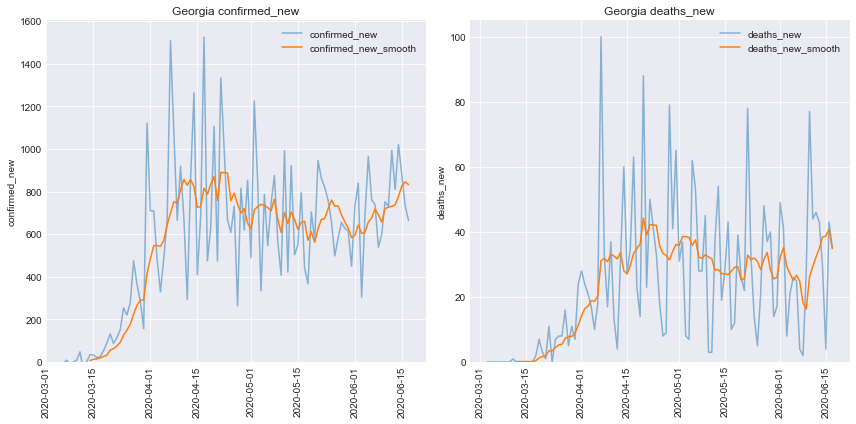

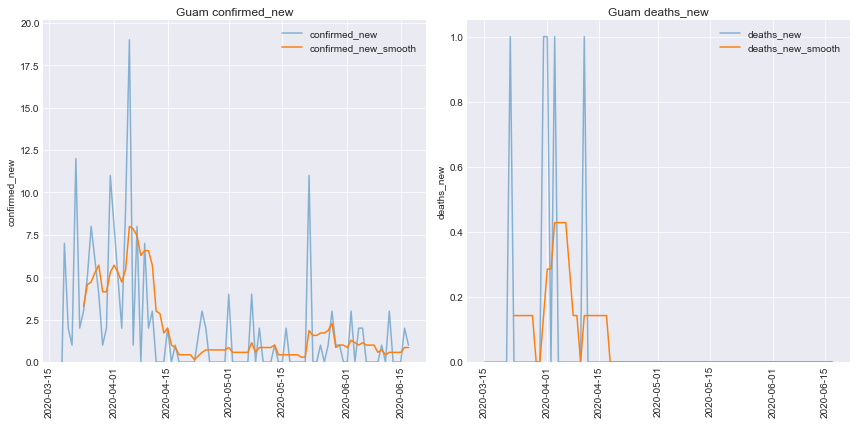

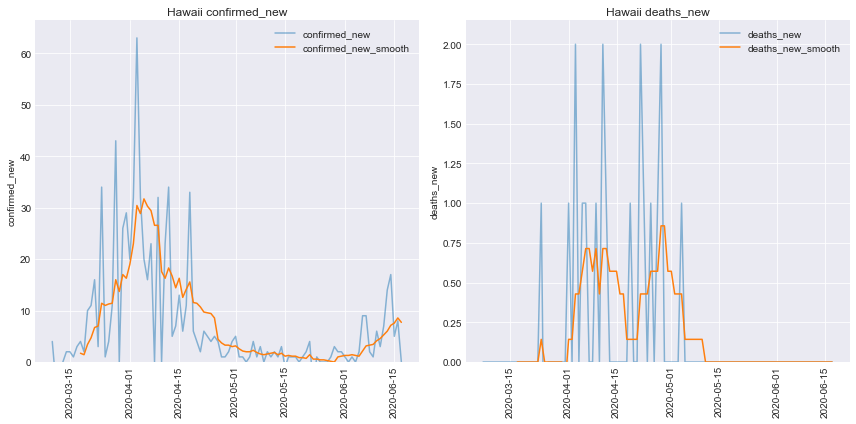

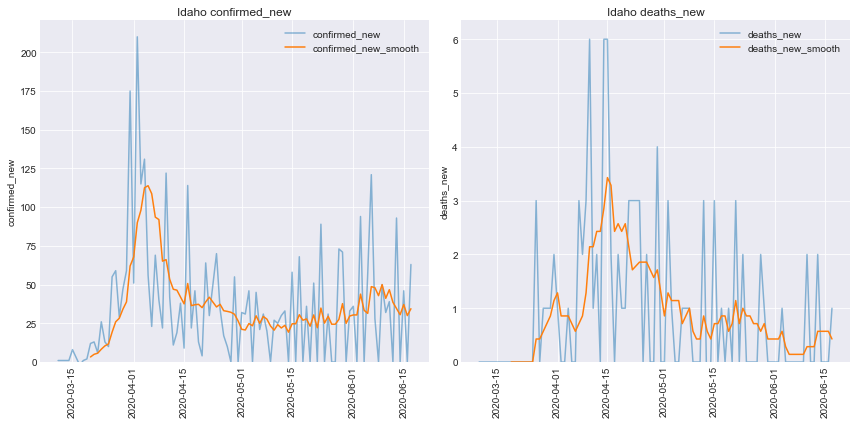

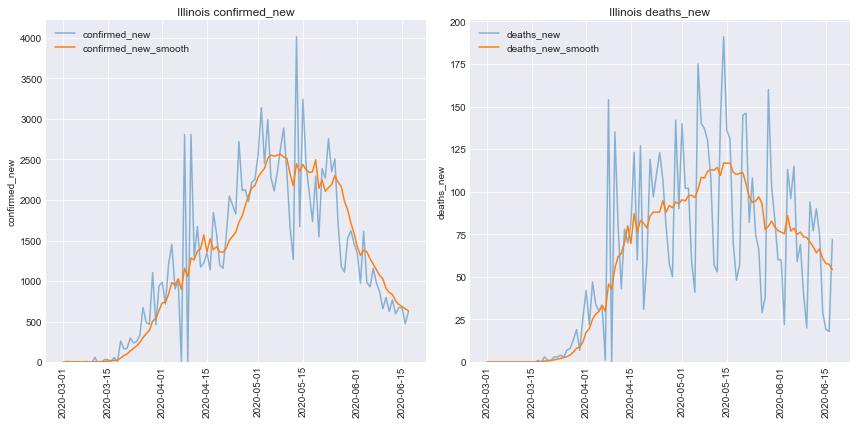

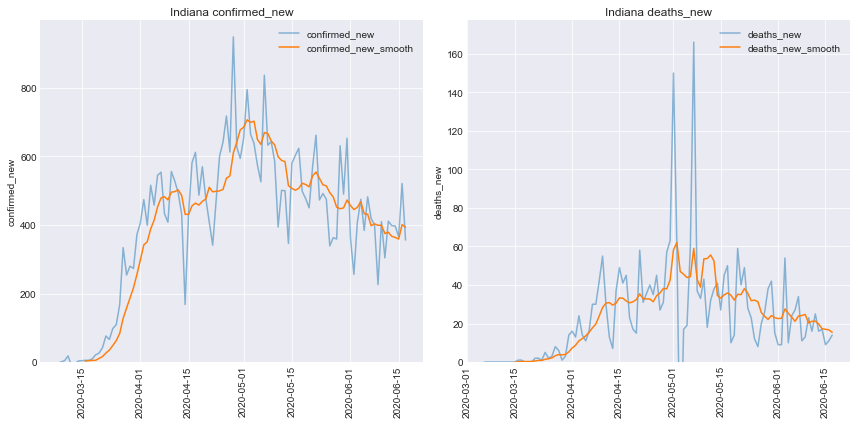

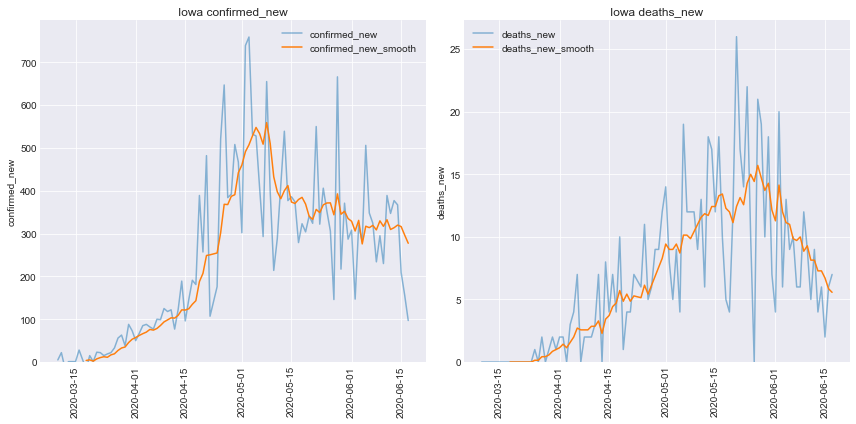

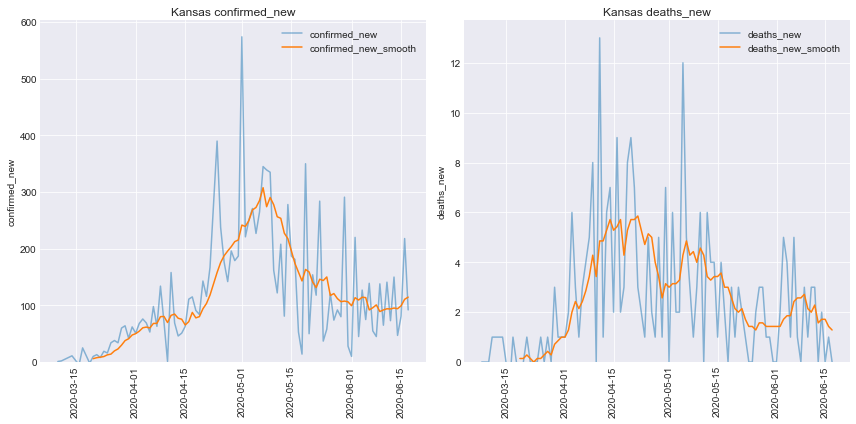

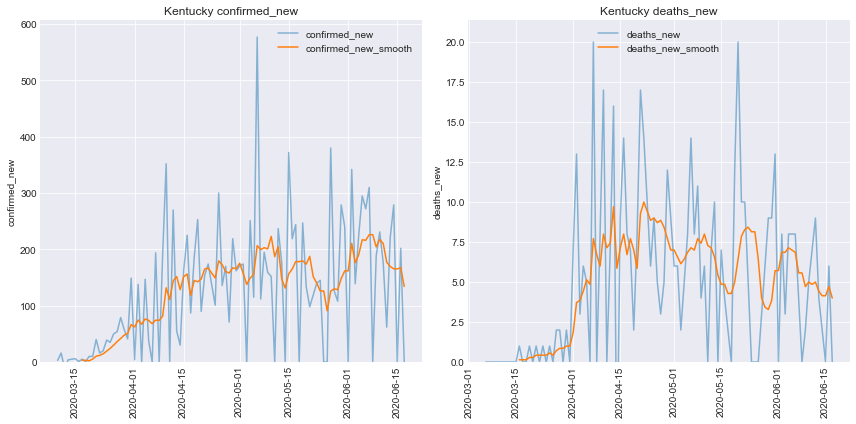

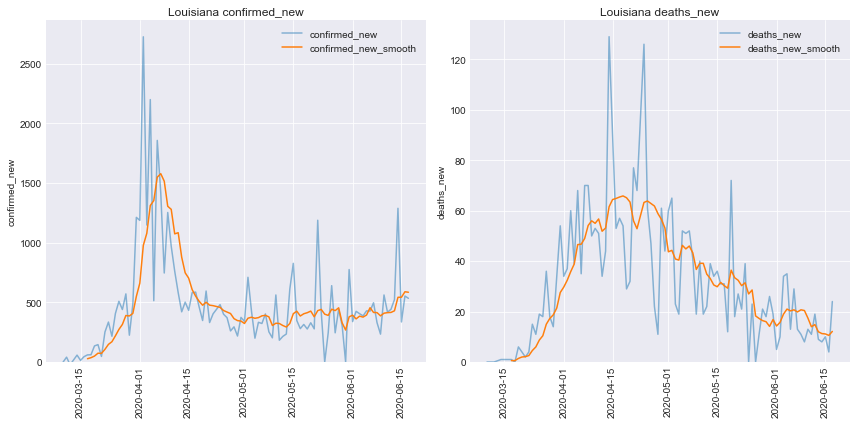

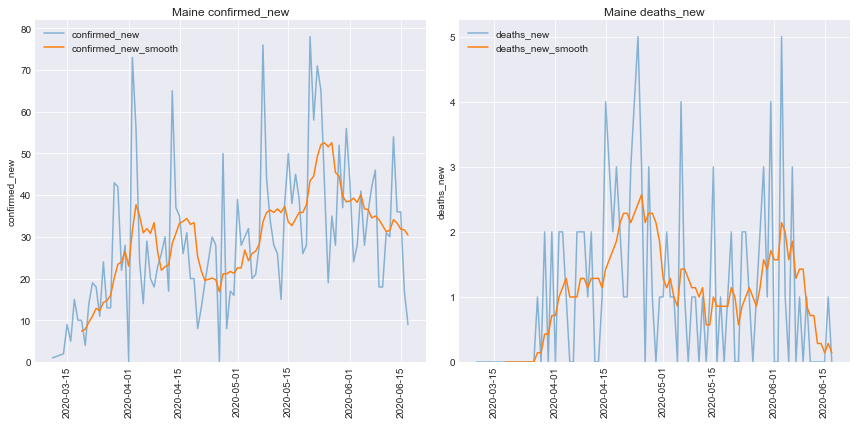

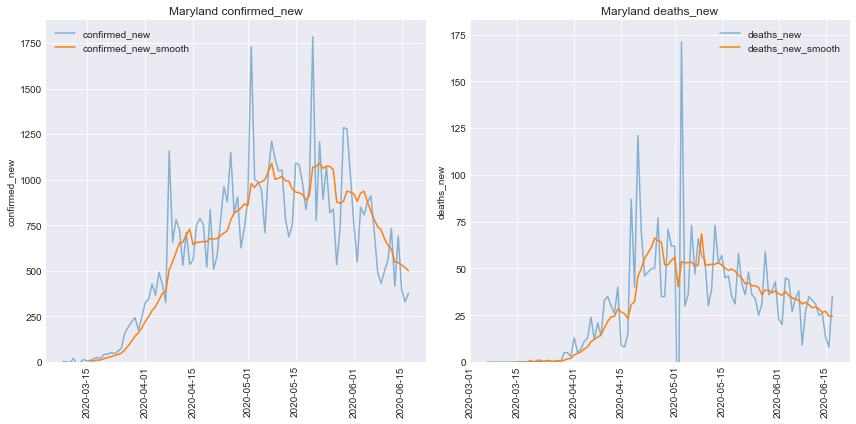

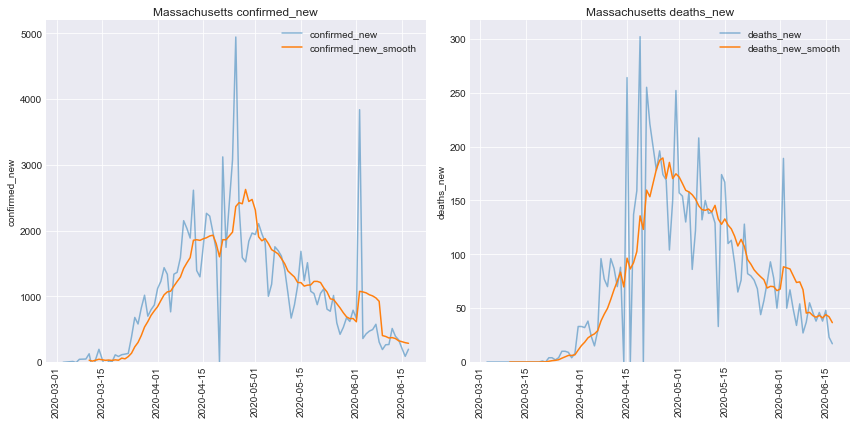

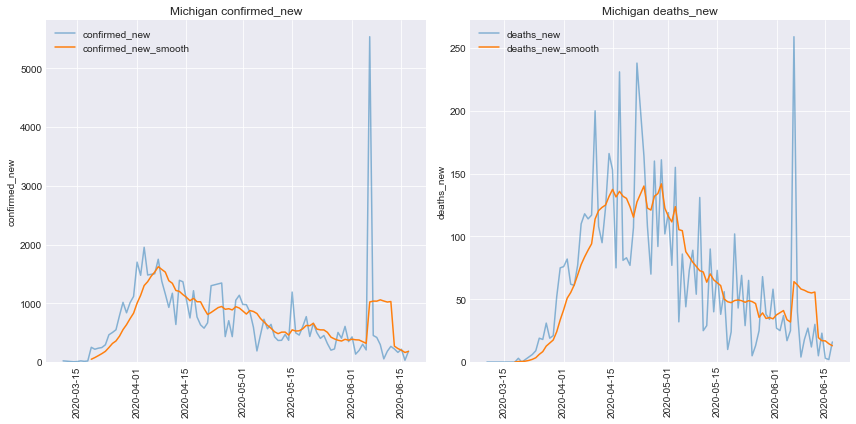

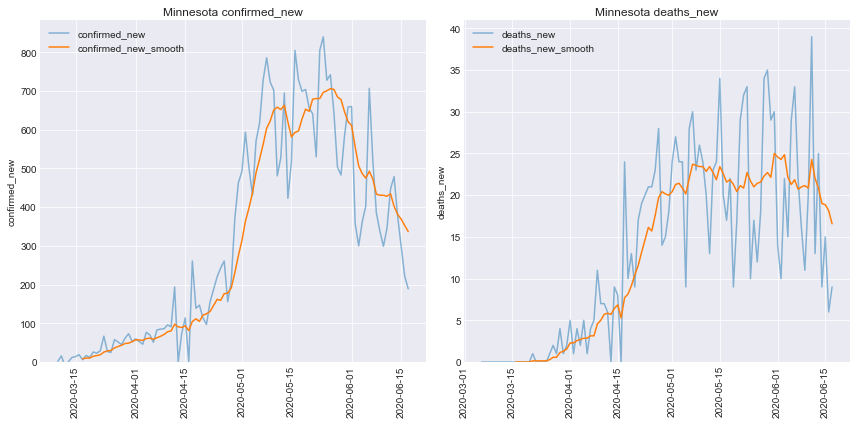

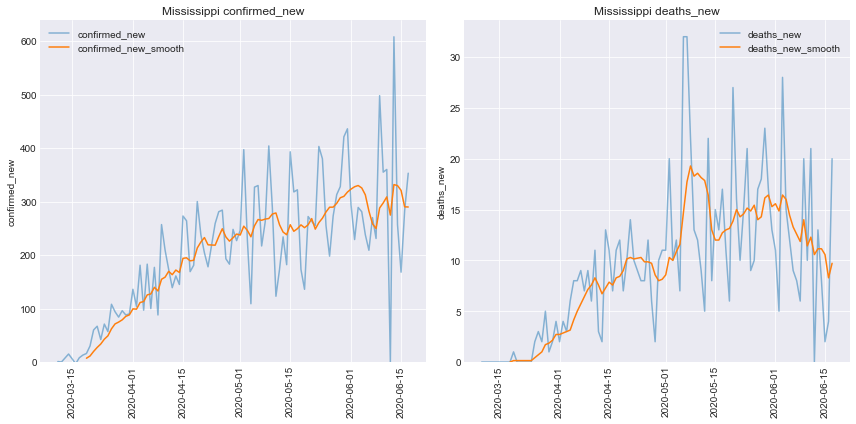

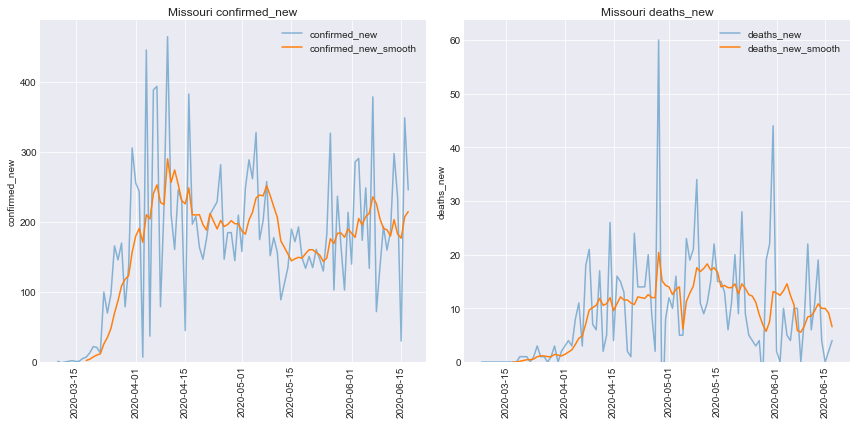

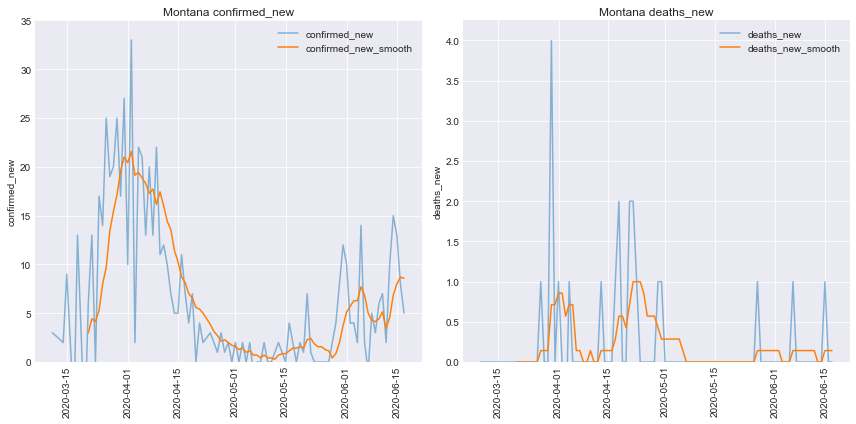

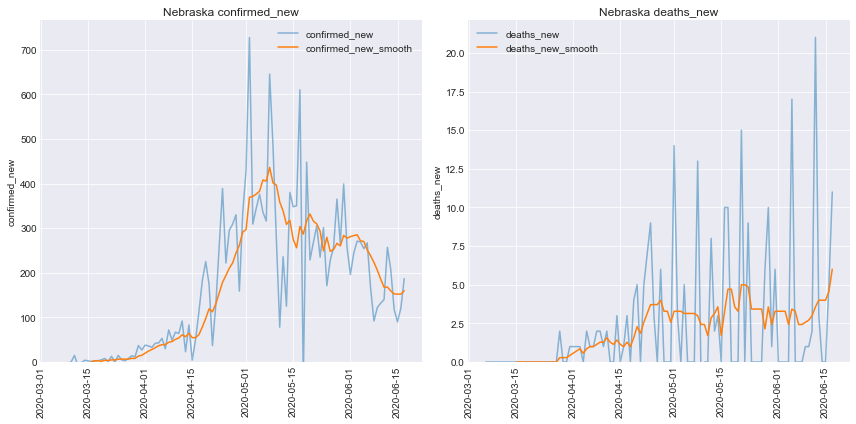

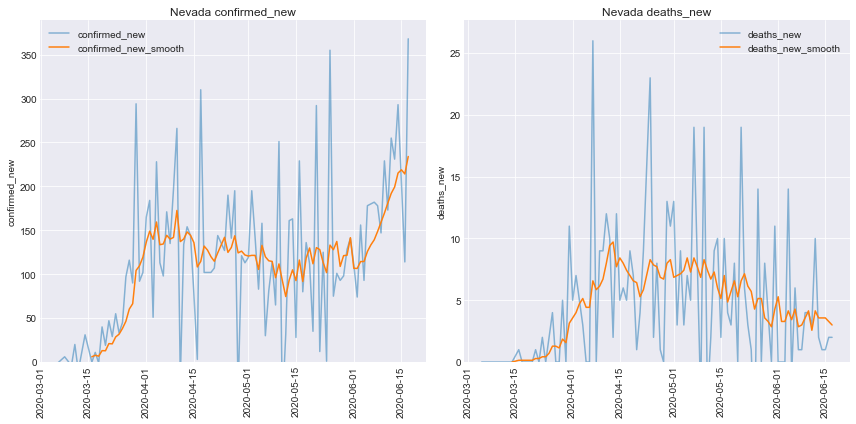

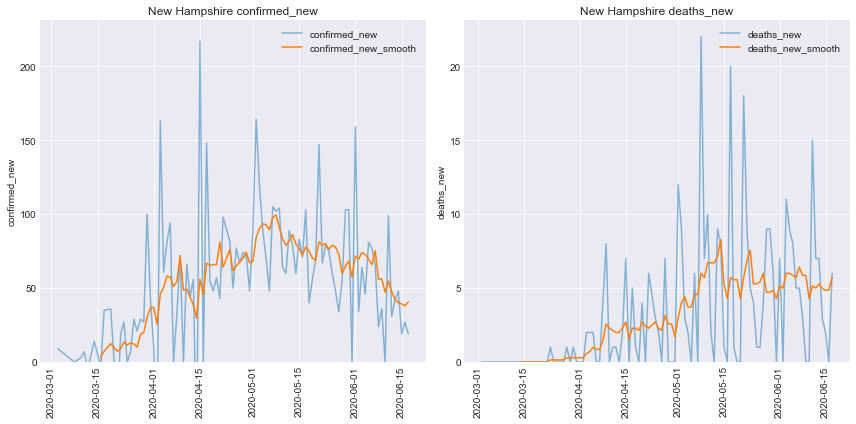

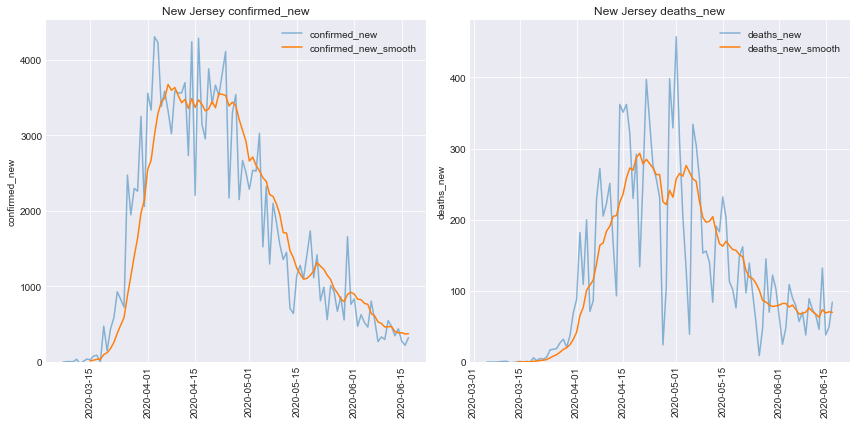

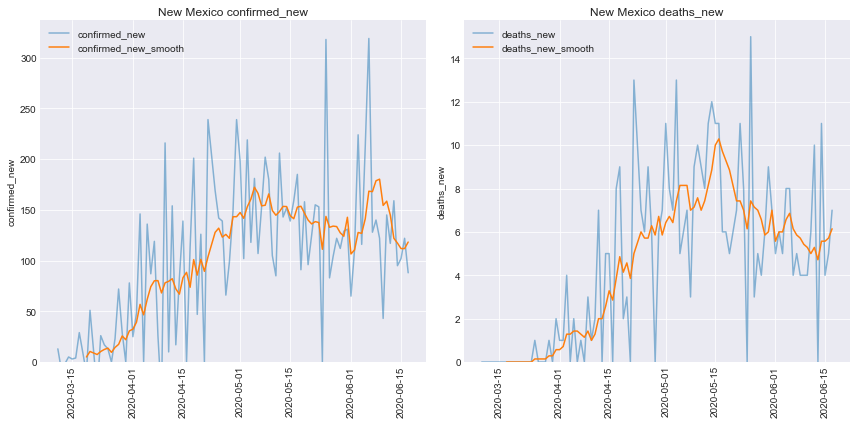

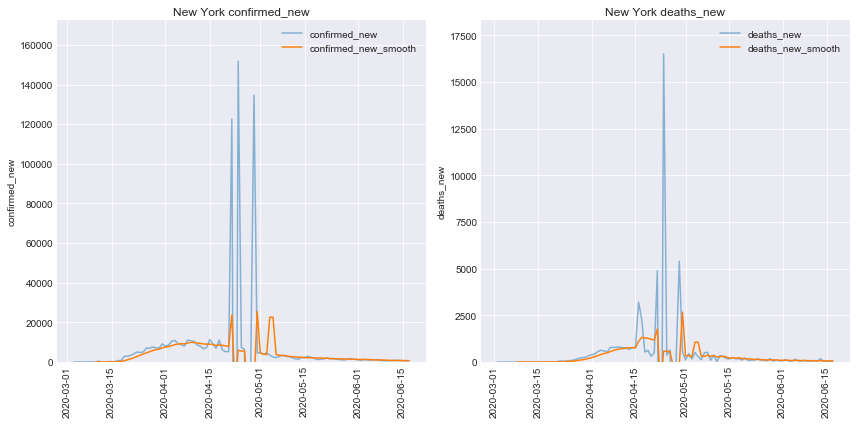

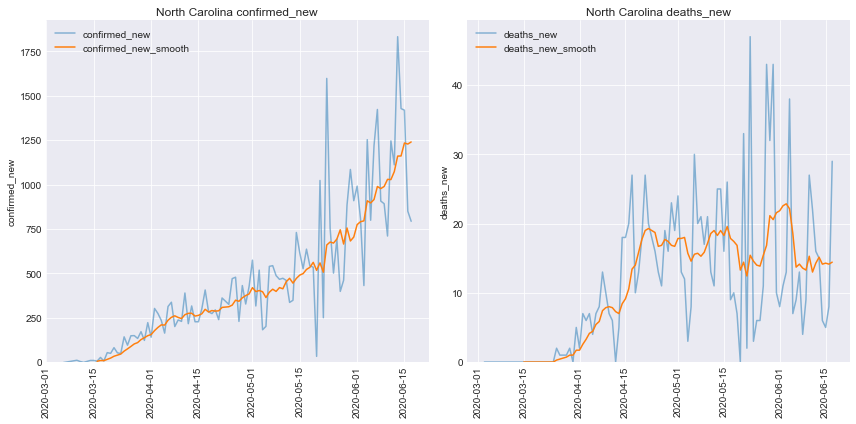

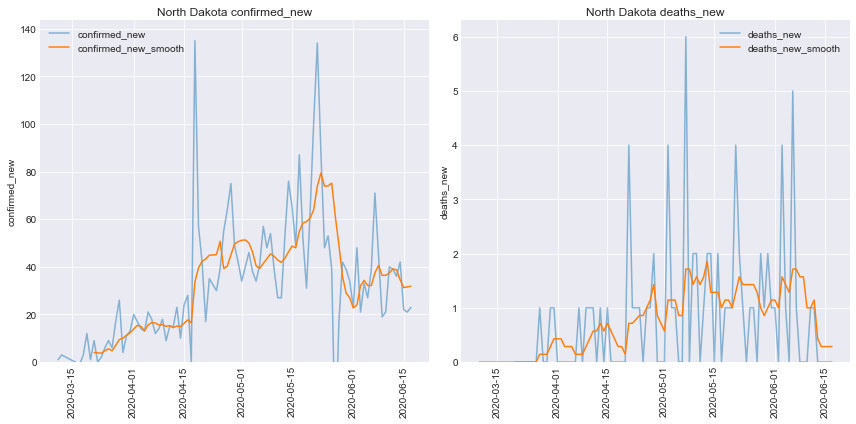

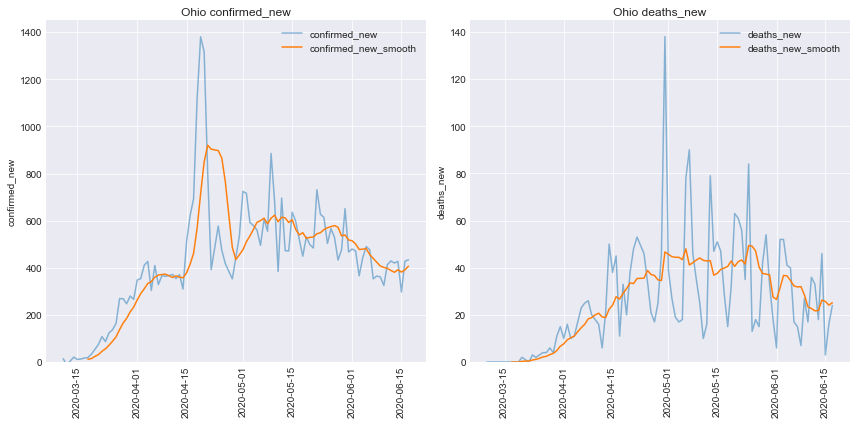

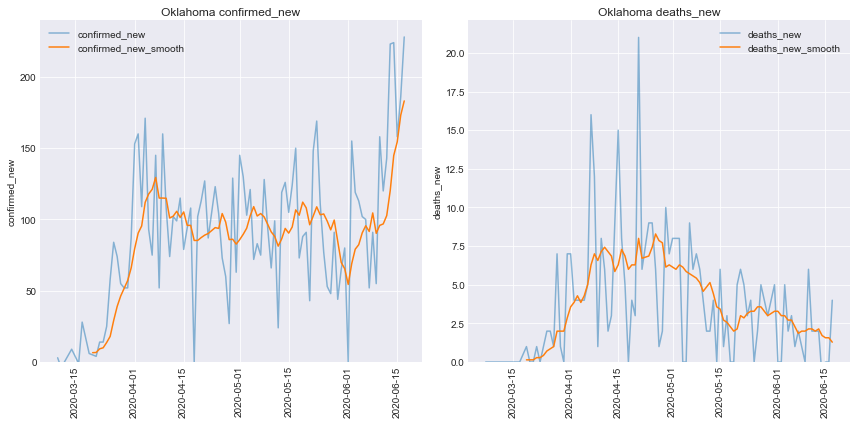

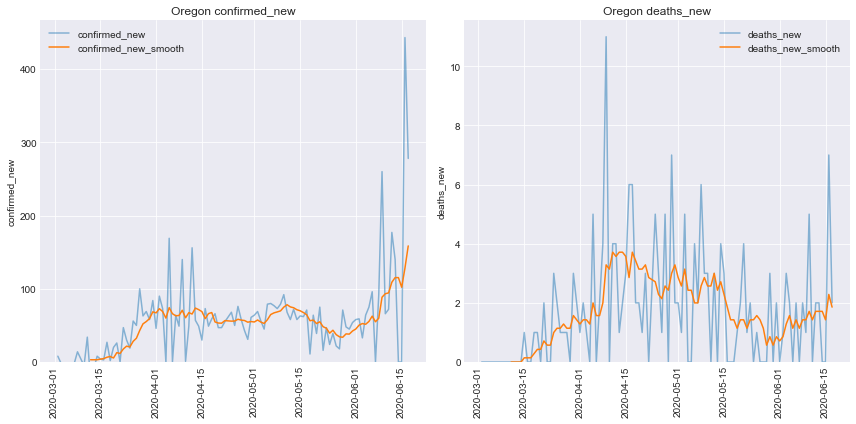

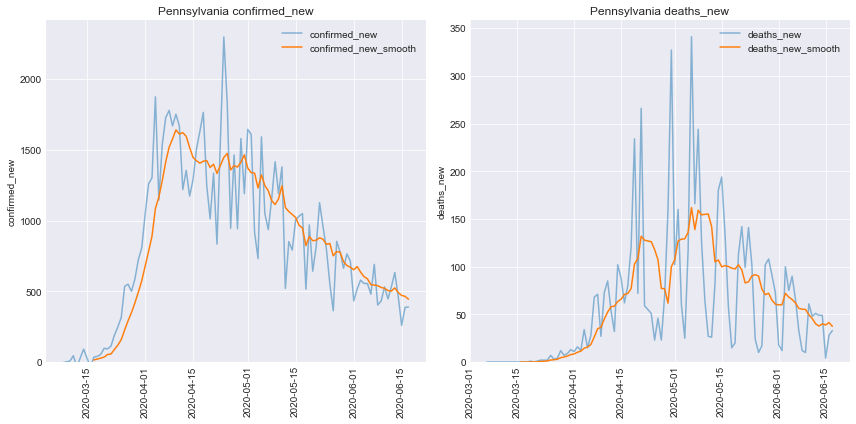

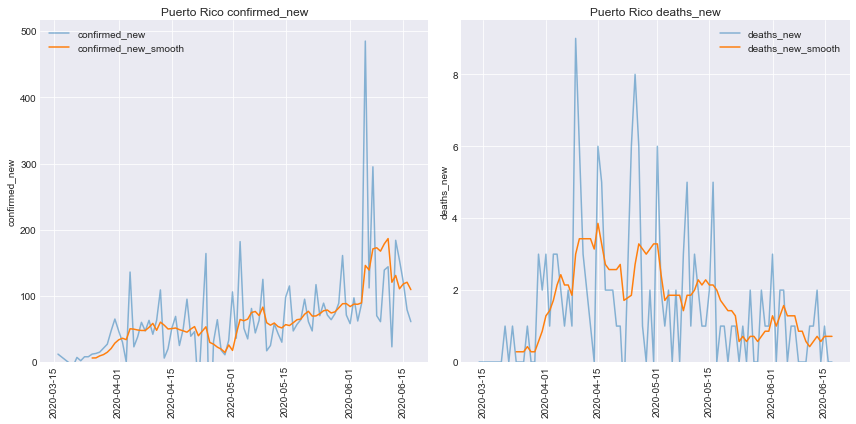

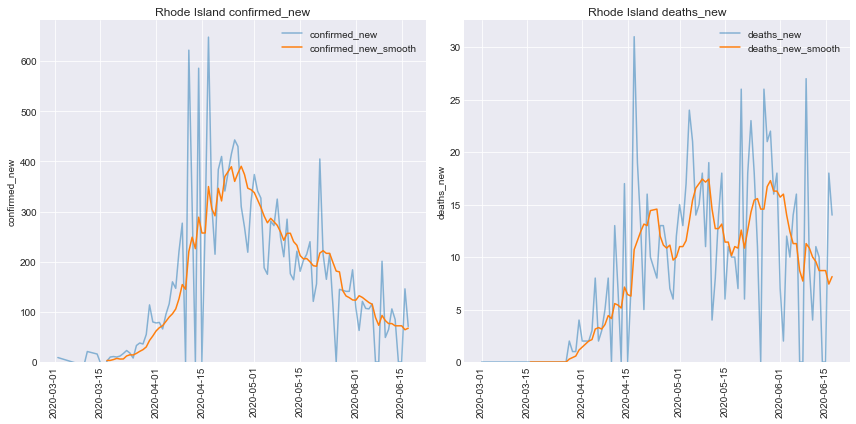

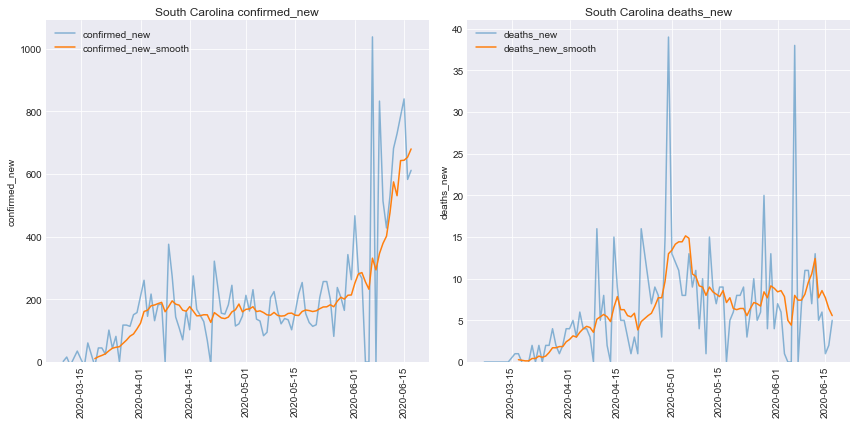

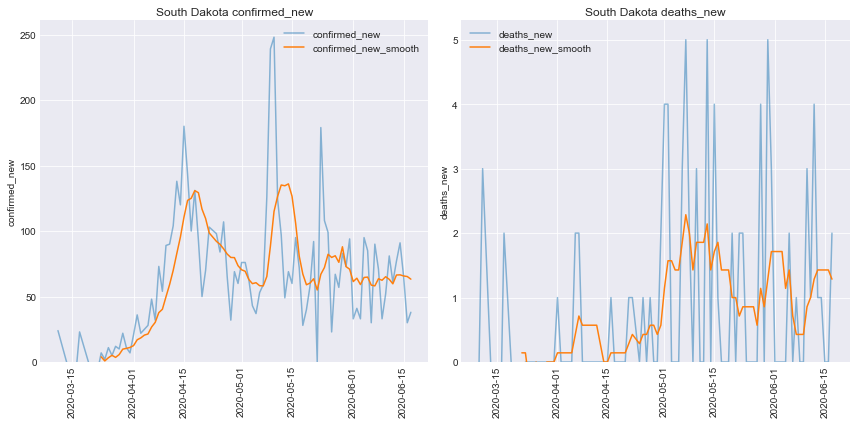

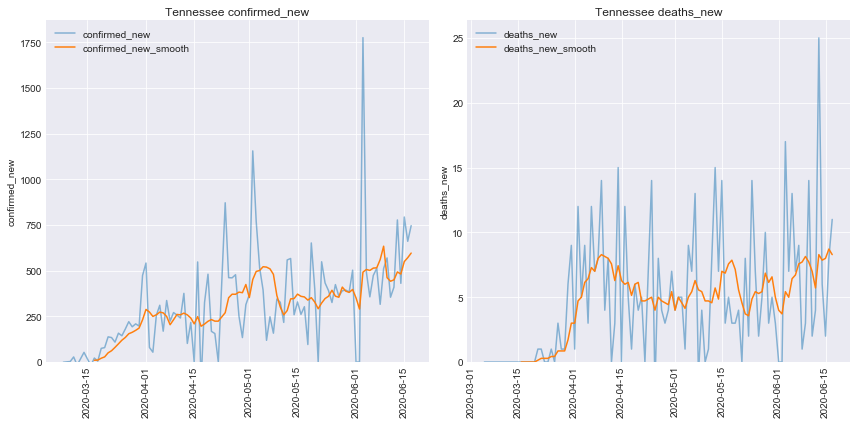

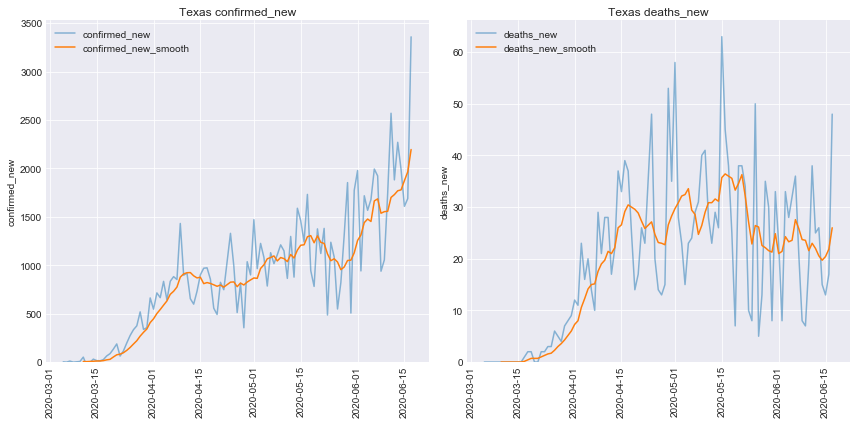

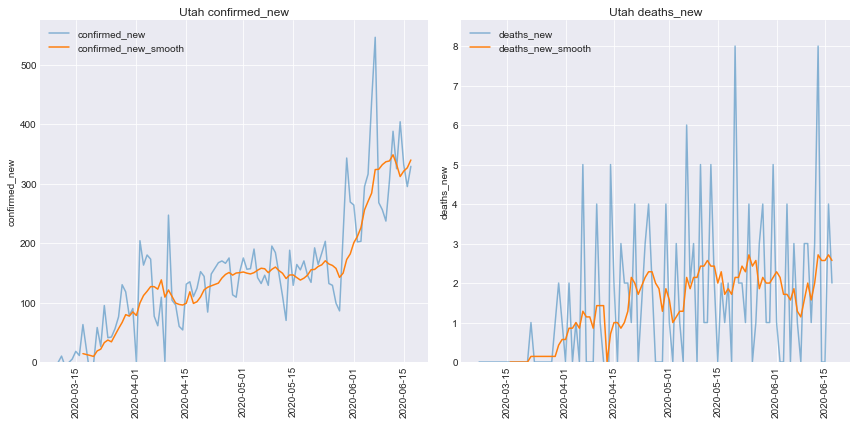

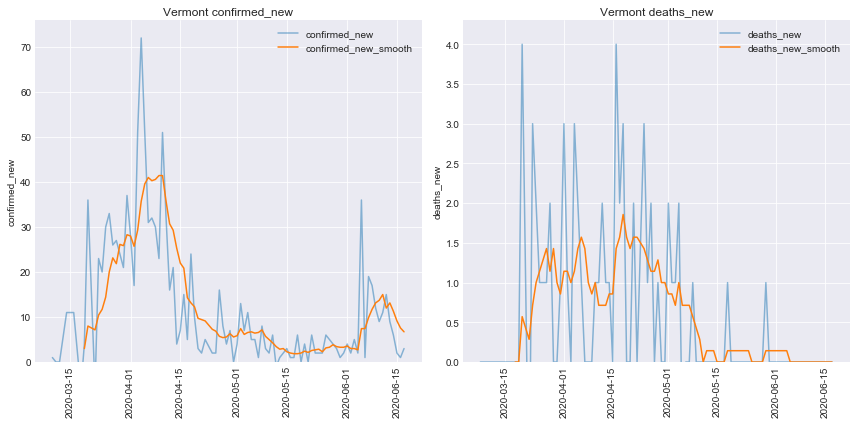

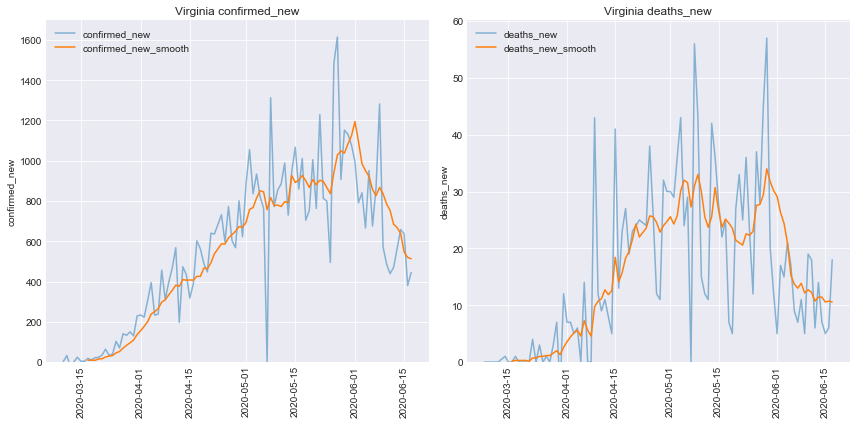

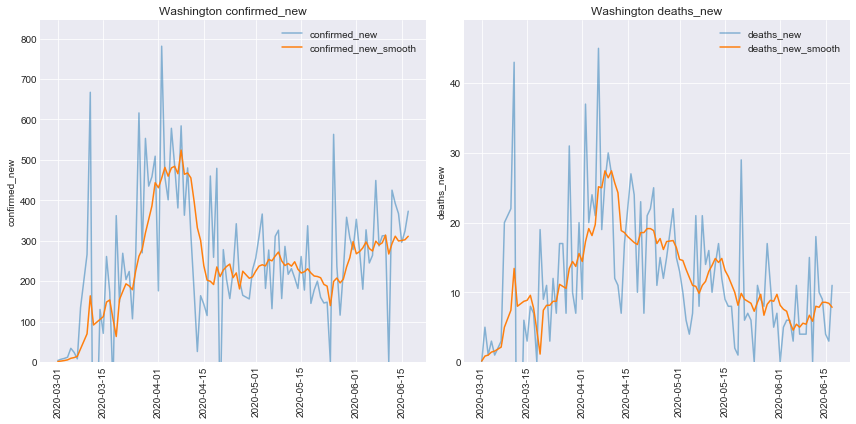

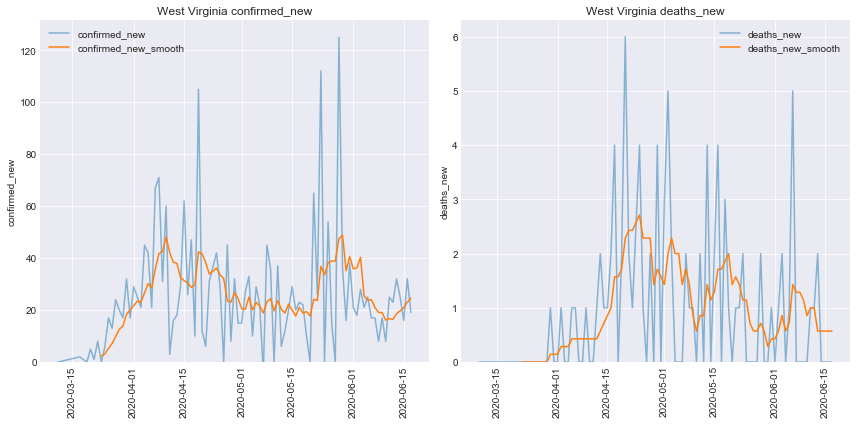

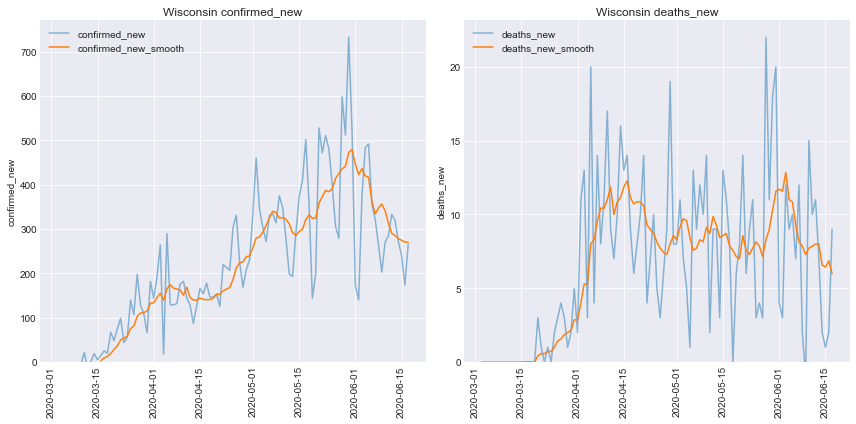

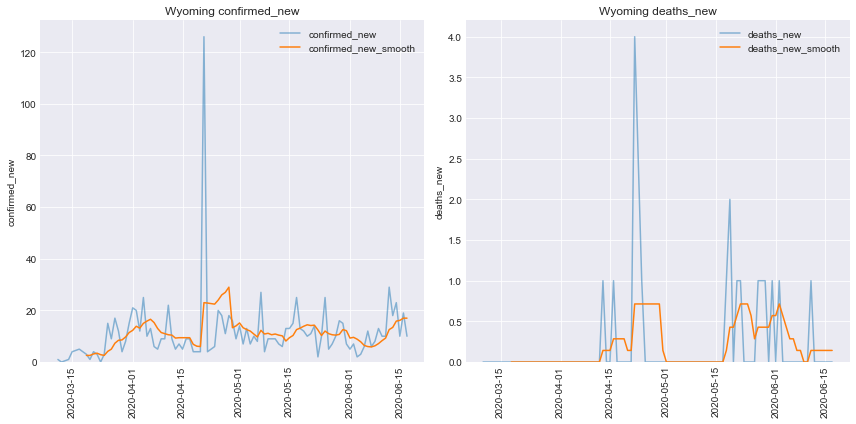

In [895]:
def plot_smoothed_trend(dfp_us_g, states, cols_plot=['confirmed_new'], dt_start=datetime.datetime(2020,3,1)):
    
    for state in states:
        i = 1
        for col_plot in cols_plot:
            plt.subplot(1,len(cols_plot),i)
            col_plot_smooth = f'{col_plot}_smooth'
            dfp_plot = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= dt_start)]
            plt.plot(dfp_plot['date'], dfp_plot[col_plot], alpha=0.5, label=col_plot)
            plt.plot(dfp_plot['date'], dfp_plot[col_plot_smooth], label=col_plot_smooth)
            plt.legend(loc='best')
            plt.xticks(rotation=90)
            plt.ylabel(col_plot)
            plt.title(f'{state} {col_plot}')
            plt.ylim(ymin=0)
            i += 1
        plt.tight_layout()
        plt.show()
    return None

#plot_smoothed_trend(dfp_us_g, ['Washington', 'Ohio', 'California', 'Texas', 'Minnesota', 'Wisconsin'], cols_plot=['confirmed_new', 'deaths_new'])

plot_smoothed_trend(dfp_us_g, states_minimum_thresh, cols_plot=['confirmed_new', 'deaths_new'])

### All states sorted by new deaths DESC

In [896]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase

state  frac_increase_deaths  frac_increase_confirmed
0                   Arkansas              0.027651                 0.056717
1                  Tennessee              0.025288                 0.020448
2                   Nebraska              0.024418                -0.036982
3                    Arizona              0.020804                 0.076418
4                     Oregon              0.014736                 0.074960
5                    Georgia              0.010921                 0.015075
6                       Utah              0.010671                 0.043765
7                     Kansas              0.007184                -0.004915
8                 California              0.006368                 0.017073
9                    Alabama              0.005792                 0.023076
10              North Dakota              0.003165                 0.004893
11             New Hampshire              0.002385                -0.030369
12                   Florida              0.002134                 0.053822
13                     Maine              0.001197                -0.017093
14  Northern Mariana Islands              0.000252                 0.000000
15                   Vermont              0.000000                 0.077032
16            Virgin Islands              0.000000                 0.000000
17                    Alaska              0.000000                 0.089816
18                 Recovered              0.000000                 0.000000
19                   Montana              0.000000                 0.024196
20                   Wyoming              0.000000                 0.022446
21                     Idaho              0.000000                 0.009336
22          Diamond Princess              0.000000                 0.000000
23            Grand Princess              0.000000                 0.000000
24                      Guam              0.000000                -0.008127
25                    Hawaii              0.000000                 0.085533
26             West Virginia             -0.000443                -0.045747
27               Puerto Rico             -0.000782                 0.027572
28                     Texas             -0.001060                 0.034084
29            South Carolina             -0.002288                 0.069222
30              South Dakota             -0.002397                -0.006968
31                Washington             -0.002522                 0.011811
32                  Kentucky             -0.004464                 0.005446
33                    Nevada             -0.004772                 0.040671
34                  Missouri             -0.004781                 0.003330
35                New Mexico             -0.008593                -0.000548
36                New Jersey             -0.010268                -0.050763
37                 Minnesota             -0.012896                -0.033158
38                   Indiana             -0.018328                -0.012370
39                  Illinois             -0.018471                -0.055059
40                 Louisiana             -0.018734                 0.023110
41      District of Columbia             -0.021331                -0.032894
42                  Maryland             -0.022826                -0.033742
43                      Ohio             -0.022916                -0.020164
44                  Delaware             -0.023979                -0.049374
45            North Carolina             -0.025115                 0.032280
46                 Wisconsin             -0.027572                -0.030940
47               Mississippi             -0.027731                -0.002273
48                  New York             -0.030227                -0.040114
49                  Colorado             -0.032982                -0.038397
50              Pennsylvania             -0.033678                -0.024269
51                  Michigan             -0.035927                -0.01

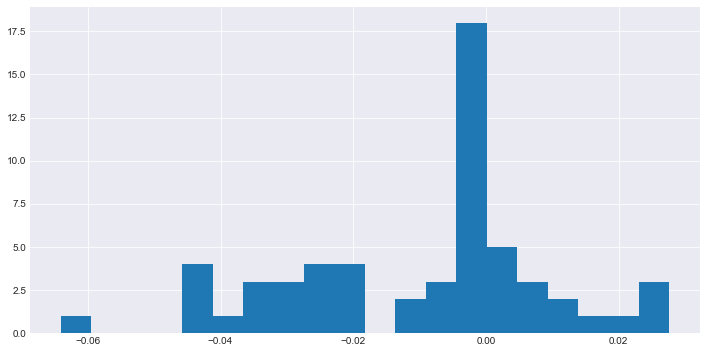

In [897]:
dfp_us_frac_new_increase.frac_increase_deaths.hist(bins=20)

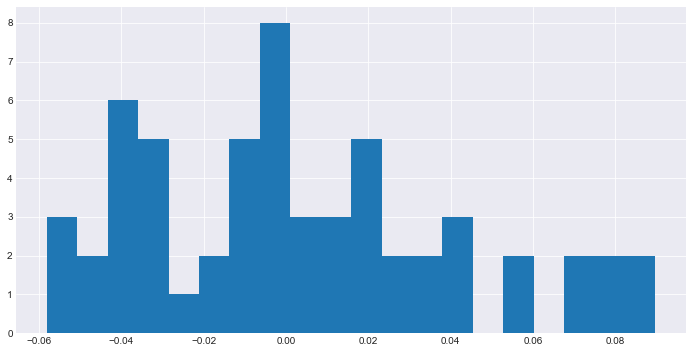

In [898]:
dfp_us_frac_new_increase.frac_increase_confirmed.hist(bins=20)

### Which states are increasing in new deaths <u>most</u> quickly?

In [899]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase.head(10)

state  frac_increase_deaths  frac_increase_confirmed
0    Arkansas              0.027651                 0.056717
1   Tennessee              0.025288                 0.020448
2    Nebraska              0.024418                -0.036982
3     Arizona              0.020804                 0.076418
4      Oregon              0.014736                 0.074960
5     Georgia              0.010921                 0.015075
6        Utah              0.010671                 0.043765
7      Kansas              0.007184                -0.004915
8  California              0.006368                 0.017073
9     Alabama              0.005792                 0.023076

### Which states are increasing in new deaths <u>least</u> quickly?

In [900]:
dfp_us_frac_new_increase.tail(10)

state  frac_increase_deaths  frac_increase_confirmed
48       New York             -0.030227                -0.040114
49       Colorado             -0.032982                -0.038397
50   Pennsylvania             -0.033678                -0.024269
51       Michigan             -0.035927                -0.013289
52  Massachusetts             -0.038731                -0.058153
53   Rhode Island             -0.041218                -0.041229
54       Oklahoma             -0.041570                 0.043157
55           Iowa             -0.044298                -0.007451
56    Connecticut             -0.044399                -0.036841
57       Virginia             -0.064109                -0.038793

### Is there a day-of-the-week effect on new deaths?

In [901]:
dfp_us_recent_1['dow'] = dfp_us_recent_1['date'].apply(lambda x: x.weekday())
dfp_us_dow = dfp_us_recent_1.dropna(subset={'deaths_new'}).copy()

In [902]:
deaths_new_col, death_pred_col = 'deaths_new', 'deaths_new_smooth_pred'
confirmed_new_col, confirmed_pred_col = 'confirmed_new', 'confirmed_new_smooth_pred'
dfp_us_dow['death_delta'] = dfp_us_dow[deaths_new_col]- dfp_us_dow[death_pred_col]
dfp_us_dow['death_rel_delta'] = (dfp_us_dow['death_delta']) / dfp_us_dow[death_pred_col]

dfp_us_dow['confirmed_delta'] = dfp_us_dow[confirmed_new_col]- dfp_us_dow[confirmed_pred_col]
dfp_us_dow['confirmed_rel_delta'] = dfp_us_dow['confirmed_delta'] / dfp_us_dow[confirmed_pred_col]
dfp_us_dow_deltas = (dfp_us_dow.groupby(['state', 'dow'], as_index=False).
                     agg({'death_delta': np.mean, 
                          'death_rel_delta': np.mean, # np.median
                          deaths_new_col: np.mean, 
                          death_pred_col: np.mean, 
                          'confirmed_delta': np.mean, 
                          'confirmed_rel_delta': np.mean}) # np.median
                    )

In [903]:
dfp_us_dow_deltas[dfp_us_dow_deltas.state == 'Washington']

state  dow  death_delta  death_rel_delta  deaths_new  \
378  Washington    0    -4.000000        -0.587302    2.666667   
379  Washington    1    -2.666667        -0.404762    4.000000   
380  Washington    2     4.000000         0.611111   10.666667   
381  Washington    3     0.666667         0.095238    7.666667   
382  Washington    4     4.000000         0.666667   10.666667   
383  Washington    5     2.000000         0.317460    8.666667   
384  Washington    6     0.000000         0.023810    6.666667   

     deaths_new_smooth_pred  confirmed_delta  confirmed_rel_delta  
378                6.666667        26.666667             0.104092  
379                6.666667        14.666667             0.050771  
380                6.666667        -4.000000            -0.027427  
381                7.000000       -88.333333            -0.299265  
382                6.666667        67.000000             0.242445  
383                6.666667        42.333333             0.148957  
384                6.666667        82.333333             0.288301

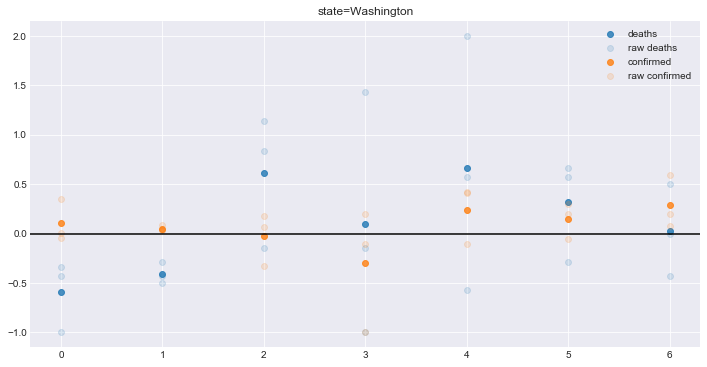

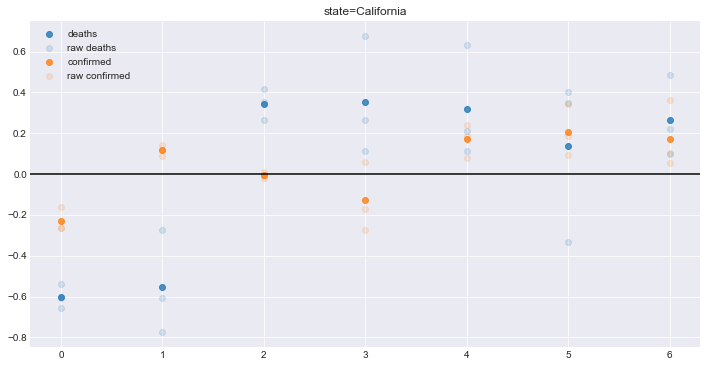

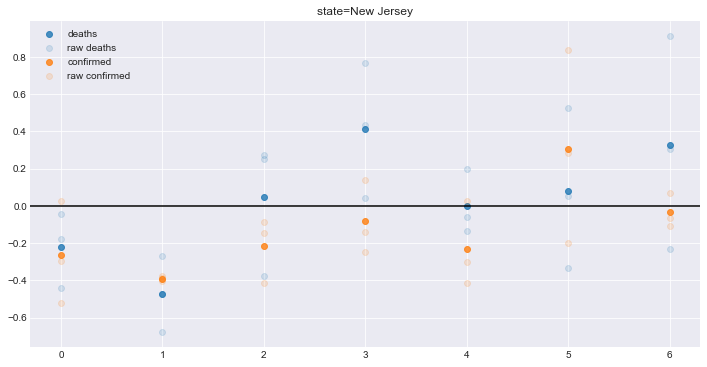

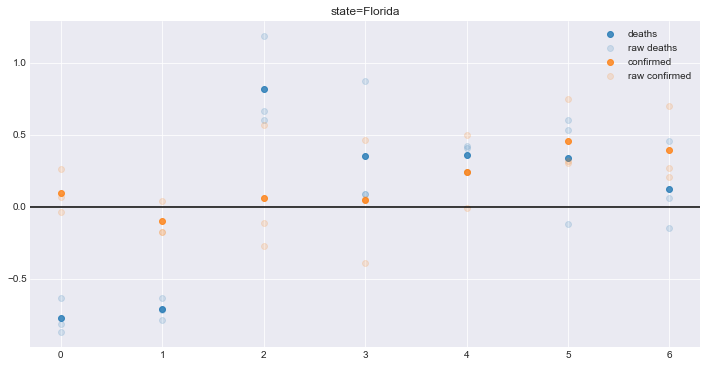

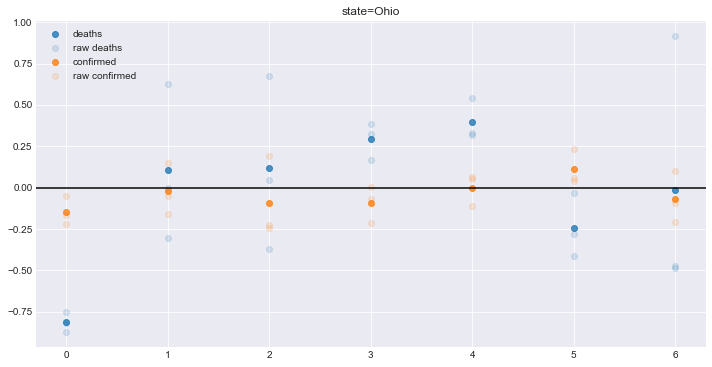

In [904]:
alpha_soft = 0.15
alpha_hard = 0.8
for state in ['Washington', 'California', 'New Jersey', 'Florida', 'Ohio']:
    dfp_plot = dfp_us_dow_deltas[(dfp_us_dow_deltas.state == state)]  #(dfp_us_dow_deltas.deaths_new >= 10) & 
    dfp_plot_raw = dfp_us_dow[dfp_us_dow.state == state]
    
    p = plt.plot(dfp_plot['dow'], dfp_plot['death_rel_delta'], 'o', alpha=alpha_hard, label='deaths')
    color = p[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['death_rel_delta'], 'o', alpha=alpha_soft, label='raw deaths', color=color)
    
    q = plt.plot(dfp_plot['dow'], dfp_plot['confirmed_rel_delta'], 'o', alpha=alpha_hard, label='confirmed')
    color = q[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['confirmed_rel_delta'], 'o', alpha=alpha_soft, label='raw confirmed', color=color)
    
    plt.legend(loc='best')
    plt.axhline(0, color='k')
    plt.title(f'state={state}')

    #plt.ylim([-0.5,0.5])
    #plt.ylim([-2,2])
    plt.show()